# Optuna Tuning | SVM
**SVM** (Classifier) hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [74]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [75]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC


### 0.2 Constants

In [76]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'svm' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [77]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [78]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [79]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [80]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [81]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [82]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "C": trial.suggest_float("C", 1e-4, 1, log=True),
        "tol": trial.suggest_float("tol", 1e-3, 1e-1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": trial.suggest_int("degree", 2, 5) if trial.params.get("kernel", "") == "poly" else 3,
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
    }

    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = SVC(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()


In [83]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 17:38:59,685] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [11]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-12 16:03:08,485] Trial 5 finished with value: 0.47633597337075617 and parameters: {'C': 0.0012294722404143379, 'tol': 0.0020130551566479487, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 5 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:09,045] Trial 11 finished with value: 0.47633597337075617 and parameters: {'C': 0.013896230728210819, 'tol': 0.0028625516541010707, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 5 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:10,496] Trial 1 finished with value: 0.47633597337075617 and parameters: {'C': 0.1835969550454928, 'tol': 0.005430303553398235, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 1 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:26,131] Trial 4 finished with value: 0.47633597337075617 and parameters: {'C': 0.001633664152301596, 'tol': 0.029253554749301944, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:27,344] Trial 6 finished with value: 0.47633597337075617 and parameters: {'C': 0.002212071341430705, 'tol': 0.0017430170724164154, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:27,736] Trial 9 finished with value: 0.47633597337075617 and parameters: {'C': 0.00015714368678366384, 'tol': 0.0013376193455713207, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:28,489] Trial 8 finished with value: 0.47633597337075617 and parameters: {'C': 0.0051009103790467395, 'tol': 0.008400507645901775, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:28,872] Trial 0 finished with value: 0.47633597337075617 and parameters: {'C': 0.04113494320918358, 'tol': 0.020603239777966794, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:34,178] Trial 7 finished with value: 0.47633597337075617 and parameters: {'C': 0.013214482223117488, 'tol': 0.0013032724668226778, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:58,561] Trial 14 finished with value: 0.47633597337075617 and parameters: {'C': 0.0006455477034526684, 'tol': 0.030880034559538836, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:03:59,241] Trial 13 finished with value: 0.47633597337075617 and parameters: {'C': 0.0016243801443744817, 'tol': 0.09040516886578366, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:04:18,690] Trial 12 finished with value: 0.47633597337075617 and parameters: {'C': 0.0009449491098267426, 'tol': 0.0392892447958403, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:04:20,087] Trial 18 finished with value: 0.47633597337075617 and parameters: {'C': 0.0006512144888050232, 'tol': 0.010182351046401158, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:04:21,228] Trial 16 finished with value: 0.47633597337075617 and parameters: {'C': 0.004629806268781293, 'tol': 0.0021310917103150467, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-12 16:04:21,315] Trial 10 finished with value: 0.504413133397007 and parameters: {'C': 0.05469867945805094, 'tol': 0.01570575287133298, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 10 with value: 0.504413133397007.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.50521445 0.50320418 0.50721805 0.50419616 0.50223282]
Average score: 0.504413133397007


[I 2025-01-12 16:04:27,753] Trial 19 finished with value: 0.47633597337075617 and parameters: {'C': 0.0001806661637799881, 'tol': 0.06820671213888325, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale'}. Best is trial 10 with value: 0.504413133397007.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:04:28,577] Trial 3 finished with value: 0.5046266695611178 and parameters: {'C': 0.06276714433299818, 'tol': 0.0014304016678754554, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.5088302  0.50169776 0.50153727 0.50695326 0.50411486]
Average score: 0.5046266695611178


[I 2025-01-12 16:04:37,479] Trial 2 finished with value: 0.49294112985789107 and parameters: {'C': 0.008448045803476259, 'tol': 0.0017782422028972745, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.49743814 0.49069869 0.49058507 0.4929658  0.49301796]
Average score: 0.49294112985789107


[I 2025-01-12 16:04:38,297] Trial 15 finished with value: 0.47633597337075617 and parameters: {'C': 0.0009066575303219904, 'tol': 0.0018458016148509655, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:04:51,957] Trial 21 finished with value: 0.47633597337075617 and parameters: {'C': 0.6938531831893717, 'tol': 0.0040726052758925275, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:05:00,400] Trial 20 finished with value: 0.47633597337075617 and parameters: {'C': 0.006069192420744035, 'tol': 0.001055838842262118, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:05:20,728] Trial 17 finished with value: 0.47633597337075617 and parameters: {'C': 0.000235880208843599, 'tol': 0.0014029833483118087, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:05:44,082] Trial 24 finished with value: 0.47633597337075617 and parameters: {'C': 0.08367880645098255, 'tol': 0.004315396492367472, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:05:50,873] Trial 23 finished with value: 0.47633597337075617 and parameters: {'C': 0.20788878972997687, 'tol': 0.014166980586708464, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:06:13,490] Trial 22 finished with value: 0.47633597337075617 and parameters: {'C': 0.7088209774511077, 'tol': 0.006688088488616206, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:06:16,114] Trial 26 finished with value: 0.5023992115427849 and parameters: {'C': 0.036873546562081846, 'tol': 0.01887573076550675, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50414098 0.5017803  0.50619286 0.50101175 0.49887017]
Average score: 0.5023992115427849


[I 2025-01-12 16:06:25,339] Trial 27 finished with value: 0.49960672589395083 and parameters: {'C': 0.02374938705844254, 'tol': 0.05606344632960494, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50612381 0.49638426 0.49979059 0.50049621 0.49523876]
Average score: 0.49960672589395083


[I 2025-01-12 16:06:29,945] Trial 28 finished with value: 0.5040496684242142 and parameters: {'C': 0.07979621447875493, 'tol': 0.01252952315079101, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50783742 0.5033197  0.50538732 0.50371911 0.49998479]
Average score: 0.5040496684242142


[I 2025-01-12 16:06:31,988] Trial 30 finished with value: 0.5044747845691273 and parameters: {'C': 0.40534550243590756, 'tol': 0.003035675206334552, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50644737 0.50207245 0.50407307 0.50861669 0.50116435]
Average score: 0.5044747845691273


[I 2025-01-12 16:06:37,228] Trial 29 finished with value: 0.5042123660716537 and parameters: {'C': 0.08115612541714606, 'tol': 0.023888554155044966, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50839616 0.50391528 0.50510075 0.50371911 0.49993051]
Average score: 0.5042123660716537


[I 2025-01-12 16:06:51,116] Trial 31 finished with value: 0.5037746647527165 and parameters: {'C': 0.04274276791539659, 'tol': 0.006299454396372149, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50518641 0.50376762 0.50619784 0.50318542 0.50053604]
Average score: 0.5037746647527165


[I 2025-01-12 16:06:51,779] Trial 25 finished with value: 0.47633597337075617 and parameters: {'C': 0.22038167418851848, 'tol': 0.016957687921695046, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:07:19,622] Trial 32 finished with value: 0.5027536332228736 and parameters: {'C': 0.021200251971841066, 'tol': 0.0029599934047868856, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50407798 0.50129878 0.50372715 0.5018875  0.50277676]
Average score: 0.5027536332228736


[I 2025-01-12 16:07:33,317] Trial 33 finished with value: 0.5029214877540659 and parameters: {'C': 0.13297068510042917, 'tol': 0.010331442172410159, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50676486 0.49927806 0.50303671 0.50555132 0.49997649]
Average score: 0.5029214877540659


[I 2025-01-12 16:07:47,336] Trial 34 finished with value: 0.5045342387104123 and parameters: {'C': 0.04604715576963867, 'tol': 0.0023253731067145603, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.51030439 0.50249971 0.50304252 0.50445528 0.50236929]
Average score: 0.5045342387104123


[I 2025-01-12 16:07:58,094] Trial 35 finished with value: 0.4919110888976649 and parameters: {'C': 0.00784066199247202, 'tol': 0.0010270979108686963, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.49583918 0.49072061 0.48872598 0.49153917 0.4927305 ]
Average score: 0.4919110888976649


[I 2025-01-12 16:08:09,992] Trial 37 finished with value: 0.4997781772490263 and parameters: {'C': 0.02414385408716352, 'tol': 0.020401875562134804, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50525498 0.49759196 0.49957758 0.50038863 0.49607774]
Average score: 0.4997781772490263


[I 2025-01-12 16:08:17,226] Trial 38 finished with value: 0.5044585941956298 and parameters: {'C': 0.34966334417297534, 'tol': 0.041301191053997884, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50634642 0.50169373 0.50447179 0.50861669 0.50116435]
Average score: 0.5044585941956298


[I 2025-01-12 16:08:23,630] Trial 36 finished with value: 0.4797727473217221 and parameters: {'C': 0.003350740898659076, 'tol': 0.003861043590905954, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.47801359 0.47923875 0.47795402 0.48469711 0.47896027]
Average score: 0.4797727473217221


[I 2025-01-12 16:08:24,611] Trial 40 finished with value: 0.5044765805262983 and parameters: {'C': 0.4518572167990645, 'tol': 0.00300566992361428, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 0.5046266695611178.


Cross validation scores: [0.50689429 0.50250541 0.50373238 0.50727854 0.50197228]
Average score: 0.5044765805262983


[I 2025-01-12 16:08:27,484] Trial 41 finished with value: 0.504681036055514 and parameters: {'C': 0.3778561266120544, 'tol': 0.008141921753743776, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 41 with value: 0.504681036055514.


Cross validation scores: [0.50662175 0.50212846 0.50435773 0.50861669 0.50168055]
Average score: 0.504681036055514


[I 2025-01-12 16:08:28,486] Trial 39 finished with value: 0.5045397492269191 and parameters: {'C': 0.08599822765699212, 'tol': 0.013150400830323298, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 41 with value: 0.504681036055514.


Cross validation scores: [0.50836121 0.50394202 0.50470086 0.5055763  0.50011835]
Average score: 0.5045397492269191


[I 2025-01-12 16:08:32,338] Trial 46 finished with value: 0.47633597337075617 and parameters: {'C': 0.010491005905607614, 'tol': 0.0021618926557305635, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 41 with value: 0.504681036055514.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:08:43,259] Trial 43 finished with value: 0.5045079789144048 and parameters: {'C': 0.9474614371478475, 'tol': 0.02574737699421185, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 41 with value: 0.504681036055514.


Cross validation scores: [0.50675558 0.50192507 0.50573374 0.5072634  0.50086211]
Average score: 0.5045079789144048


[I 2025-01-12 16:08:51,429] Trial 42 finished with value: 0.5044828666115759 and parameters: {'C': 0.10456337684830128, 'tol': 0.03647786298811229, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 41 with value: 0.504681036055514.


Cross validation scores: [0.5088302  0.50233213 0.50328475 0.50620484 0.50176241]
Average score: 0.5044828666115759


[I 2025-01-12 16:09:15,410] Trial 51 finished with value: 0.47633597337075617 and parameters: {'C': 0.6978831336403022, 'tol': 0.0025705798839002494, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 41 with value: 0.504681036055514.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:09:23,006] Trial 44 finished with value: 0.5046972983533191 and parameters: {'C': 0.14614286212197286, 'tol': 0.024113306616239116, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 44 with value: 0.5046972983533191.


Cross validation scores: [0.50695215 0.50170309 0.50426704 0.50752573 0.50303849]
Average score: 0.5046972983533191


[I 2025-01-12 16:09:30,836] Trial 45 finished with value: 0.5042036967344078 and parameters: {'C': 0.05535451079051744, 'tol': 0.0016236898665302865, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 44 with value: 0.5046972983533191.


Cross validation scores: [0.50515725 0.50314808 0.50639614 0.50413958 0.50217743]
Average score: 0.5042036967344078


[I 2025-01-12 16:10:14,319] Trial 47 finished with value: 0.5022609926735359 and parameters: {'C': 0.016466017135076158, 'tol': 0.0025342179059685077, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 44 with value: 0.5046972983533191.


Cross validation scores: [0.50435159 0.50044468 0.50163979 0.50213359 0.50273531]
Average score: 0.5022609926735359


[I 2025-01-12 16:10:18,704] Trial 48 finished with value: 0.5048531976119358 and parameters: {'C': 0.05035204860521874, 'tol': 0.004700366665727933, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.50958493 0.50309519 0.50315324 0.50428215 0.50415049]
Average score: 0.5048531976119358


[I 2025-01-12 16:10:20,591] Trial 52 finished with value: 0.504576237938821 and parameters: {'C': 0.5114609893358996, 'tol': 0.005619429980117491, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.50728104 0.50239302 0.5042961  0.50716162 0.50174941]
Average score: 0.504576237938821


[I 2025-01-12 16:10:23,204] Trial 57 finished with value: 0.47633597337075617 and parameters: {'C': 0.02932458529190184, 'tol': 0.02751421527654895, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:10:26,932] Trial 49 finished with value: 0.47633597337075617 and parameters: {'C': 0.27817582424317244, 'tol': 0.0034356767665528953, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:10:32,936] Trial 53 finished with value: 0.5045505332083582 and parameters: {'C': 0.16906718715380362, 'tol': 0.007716444438437722, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.50648671 0.50092624 0.50532834 0.50753318 0.5024782 ]
Average score: 0.5045505332083582


[I 2025-01-12 16:10:34,124] Trial 54 finished with value: 0.5045551730623128 and parameters: {'C': 0.2531072328770872, 'tol': 0.00117780086947144, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.50664847 0.50115215 0.50504376 0.5077669  0.50216459]
Average score: 0.5045551730623128


[I 2025-01-12 16:10:36,885] Trial 55 finished with value: 0.5044648822541722 and parameters: {'C': 0.9142512251838987, 'tol': 0.011946443242451888, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.50675558 0.50198107 0.50511898 0.50777231 0.50069647]
Average score: 0.5044648822541722


[I 2025-01-12 16:10:38,771] Trial 50 finished with value: 0.5034259859015429 and parameters: {'C': 0.3609918470012202, 'tol': 0.0014564806995860714, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.50613864 0.50068025 0.50288492 0.50664847 0.50077766]
Average score: 0.5034259859015429


[I 2025-01-12 16:10:44,180] Trial 56 finished with value: 0.5044973146154819 and parameters: {'C': 0.947566804483869, 'tol': 0.008502515805518824, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.50675558 0.50198107 0.50511898 0.50771357 0.50091737]
Average score: 0.5044973146154819


[I 2025-01-12 16:10:59,884] Trial 60 finished with value: 0.47633597337075617 and parameters: {'C': 0.11201557811293839, 'tol': 0.0332440983332398, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 48 with value: 0.5048531976119358.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:11:29,142] Trial 59 finished with value: 0.5049307473930569 and parameters: {'C': 0.0706260375722052, 'tol': 0.048967041671478355, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50868975 0.5047579  0.50593383 0.50542598 0.49984629]
Average score: 0.5049307473930569


[I 2025-01-12 16:11:38,226] Trial 58 finished with value: 0.5029214919243761 and parameters: {'C': 0.13693308270079452, 'tol': 0.014096599183856976, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50670665 0.49971974 0.50298044 0.50555132 0.49964931]
Average score: 0.5029214919243761


[I 2025-01-12 16:12:15,016] Trial 62 finished with value: 0.5046221269114444 and parameters: {'C': 0.5939203181317695, 'tol': 0.005142796320127763, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50728104 0.50216856 0.50451604 0.50767357 0.50147142]
Average score: 0.5046221269114444


[I 2025-01-12 16:12:19,604] Trial 61 finished with value: 0.5048269118964168 and parameters: {'C': 0.18322803317349187, 'tol': 0.005157161740155672, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50694757 0.50159895 0.50515611 0.50806545 0.50236648]
Average score: 0.5048269118964168


[I 2025-01-12 16:12:22,048] Trial 64 finished with value: 0.504463385051334 and parameters: {'C': 0.5496711937227075, 'tol': 0.0076824053980580715, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50728104 0.50222464 0.5040115  0.50716162 0.50163814]
Average score: 0.504463385051334


[I 2025-01-12 16:12:23,183] Trial 63 finished with value: 0.5042378766337586 and parameters: {'C': 0.06030002703927049, 'tol': 0.006100970922997086, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.5061144  0.50253304 0.50629028 0.50447344 0.50177822]
Average score: 0.5042378766337586


[I 2025-01-12 16:12:28,712] Trial 71 finished with value: 0.47633597337075617 and parameters: {'C': 0.0652594046158419, 'tol': 0.08807332204699243, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:12:34,080] Trial 66 finished with value: 0.5045411264348919 and parameters: {'C': 0.25044743874556896, 'tol': 0.001123755355927806, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50670665 0.50120767 0.50510112 0.50782565 0.50186455]
Average score: 0.5045411264348919


[I 2025-01-12 16:12:38,991] Trial 67 finished with value: 0.5047257272721354 and parameters: {'C': 0.2812776610660507, 'tol': 0.0012727046918342344, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50704481 0.50147995 0.50504376 0.5082299  0.50183022]
Average score: 0.5047257272721354


[I 2025-01-12 16:12:45,692] Trial 69 finished with value: 0.5047584602577275 and parameters: {'C': 0.13782379596091338, 'tol': 0.004354643617607277, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50671577 0.50198176 0.50407804 0.50758434 0.50343239]
Average score: 0.5047584602577275


[I 2025-01-12 16:13:13,846] Trial 70 finished with value: 0.5036135796034568 and parameters: {'C': 0.329412428396867, 'tol': 0.009998831179613777, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50619659 0.50105218 0.50327965 0.50670665 0.50083282]
Average score: 0.5036135796034568


[I 2025-01-12 16:13:23,773] Trial 79 finished with value: 0.47633597337075617 and parameters: {'C': 0.13273704783748105, 'tol': 0.016739739066492336, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:13:33,796] Trial 72 finished with value: 0.5023135992559183 and parameters: {'C': 0.036118483759729175, 'tol': 0.058843108025717114, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50431063 0.50137789 0.50642433 0.50047873 0.49897641]
Average score: 0.5023135992559183


[I 2025-01-12 16:14:09,163] Trial 73 finished with value: 0.5046444268399244 and parameters: {'C': 0.6270916557899437, 'tol': 0.04726237651377479, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50722254 0.5021125  0.50501944 0.50767357 0.50119407]
Average score: 0.5046444268399244


[I 2025-01-12 16:14:17,264] Trial 74 finished with value: 0.5045496818150629 and parameters: {'C': 0.17069317331568262, 'tol': 0.004672743017591665, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50642867 0.50098156 0.5052709  0.50753318 0.5025341 ]
Average score: 0.5045496818150629


[I 2025-01-12 16:14:23,502] Trial 75 finished with value: 0.5045133720389031 and parameters: {'C': 0.0983400059254032, 'tol': 0.004870167973783908, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5049307473930569.


Cross validation scores: [0.50900828 0.50306102 0.50367939 0.50599932 0.50081885]
Average score: 0.5045133720389031


[I 2025-01-12 16:14:25,699] Trial 76 finished with value: 0.5049452135957685 and parameters: {'C': 0.20732366365512778, 'tol': 0.006786409350268309, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50659823 0.5018758  0.50584931 0.50800624 0.50239648]
Average score: 0.5049452135957685


[I 2025-01-12 16:14:28,111] Trial 77 finished with value: 0.5048199935633428 and parameters: {'C': 0.06652868649264229, 'tol': 0.0035002023490388243, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.5089865  0.50437603 0.5056532  0.50409389 0.50099035]
Average score: 0.5048199935633428


[I 2025-01-12 16:14:43,629] Trial 78 finished with value: 0.5047213730189982 and parameters: {'C': 0.04681777470530157, 'tol': 0.07148649256099868, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.51030439 0.50233221 0.50276268 0.50513691 0.50307068]
Average score: 0.5047213730189982


[I 2025-01-12 16:14:49,912] Trial 80 finished with value: 0.5046859269968549 and parameters: {'C': 0.14634869151275057, 'tol': 0.0037656552586913202, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50695215 0.50170309 0.50421018 0.50752573 0.50303849]
Average score: 0.5046859269968549


[I 2025-01-12 16:14:53,402] Trial 68 finished with value: 0.47633597337075617 and parameters: {'C': 0.4824266269539777, 'tol': 0.0018450125679298282, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:15:19,251] Trial 81 finished with value: 0.5042854653871243 and parameters: {'C': 0.11668636897948284, 'tol': 0.009334327452544172, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50800303 0.50208387 0.50289153 0.50619834 0.50225056]
Average score: 0.5042854653871243


[I 2025-01-12 16:15:21,071] Trial 82 finished with value: 0.5046785198491329 and parameters: {'C': 0.31112296453471955, 'tol': 0.0016165617958536506, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.5072634  0.50136864 0.50498644 0.50827731 0.50149681]
Average score: 0.5046785198491329


[I 2025-01-12 16:15:31,688] Trial 83 finished with value: 0.5045517722234613 and parameters: {'C': 0.08383674885029305, 'tol': 0.0012904809691975019, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50842029 0.50405542 0.50492919 0.5050723  0.50028166]
Average score: 0.5045517722234613


[I 2025-01-12 16:16:01,053] Trial 84 finished with value: 0.5044540377479437 and parameters: {'C': 0.39439303453131674, 'tol': 0.04602305936238381, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.5065636  0.50261789 0.50418685 0.50757139 0.50133046]
Average score: 0.5044540377479437


[I 2025-01-12 16:16:07,156] Trial 90 finished with value: 0.47633597337075617 and parameters: {'C': 0.07178492138353078, 'tol': 0.0053272158812540035, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:16:12,259] Trial 85 finished with value: 0.5047184474775872 and parameters: {'C': 0.23123320269994194, 'tol': 0.04981788334652124, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.5068231  0.50165268 0.50533081 0.5080021  0.50178354]
Average score: 0.5047184474775872


[I 2025-01-12 16:16:23,989] Trial 88 finished with value: 0.5002590377807438 and parameters: {'C': 0.028649131265947182, 'tol': 0.004473314365536507, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.
[I 2025-01-12 16:16:24,029] Trial 86 finished with value: 0.5047349675482509 and parameters: {'C': 0.2865366057492884, 'tol': 0.07395739385097076, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50679573 0.4982535  0.50144218 0.49931023 0.49549355]
Average score: 0.5002590377807438
Cross validation scores: [0.5073219  0.50142428 0.50498644 0.508112   0.50183022]
Average score: 0.5047349675482509


[I 2025-01-12 16:16:26,417] Trial 87 finished with value: 0.5048076395958724 and parameters: {'C': 0.21468345743496875, 'tol': 0.006735602277817848, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50648203 0.5018758  0.50561858 0.50788858 0.50217321]
Average score: 0.5048076395958724


[I 2025-01-12 16:16:33,713] Trial 65 finished with value: 0.4778502633076565 and parameters: {'C': 0.18082684546364358, 'tol': 0.007895986288990785, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.47745369 0.47736784 0.47739646 0.47957964 0.47745369]
Average score: 0.4778502633076565


[I 2025-01-12 16:16:45,355] Trial 89 finished with value: 0.5045630214043395 and parameters: {'C': 0.0496044527817298, 'tol': 0.0034809663313443264, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50982419 0.50320773 0.5032094  0.50433891 0.50223487]
Average score: 0.5045630214043395


[I 2025-01-12 16:16:56,531] Trial 91 finished with value: 0.5044526442941472 and parameters: {'C': 0.03492421258181799, 'tol': 0.09877445078086099, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50768646 0.50349365 0.50426378 0.50453024 0.50228909]
Average score: 0.5044526442941472


[I 2025-01-12 16:16:58,427] Trial 97 finished with value: 0.47633597337075617 and parameters: {'C': 0.2103751152209902, 'tol': 0.05763398606868923, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 16:17:06,006] Trial 93 finished with value: 0.49590817378459917 and parameters: {'C': 0.016325002850038368, 'tol': 0.0058689004042716915, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50134729 0.49250942 0.49589515 0.49584526 0.49394375]
Average score: 0.49590817378459917


[I 2025-01-12 16:17:06,689] Trial 92 finished with value: 0.5044871847153213 and parameters: {'C': 0.09591320845695152, 'tol': 0.07447705468387714, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50876337 0.50300479 0.50356649 0.50617267 0.50092861]
Average score: 0.5044871847153213


[I 2025-01-12 16:17:14,991] Trial 94 finished with value: 0.5038321745446102 and parameters: {'C': 0.04813331964924016, 'tol': 0.003364944058867588, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.5047069  0.50290295 0.50690615 0.50234999 0.50229488]
Average score: 0.5038321745446102


[I 2025-01-12 16:17:28,523] Trial 95 finished with value: 0.5044390355764687 and parameters: {'C': 0.15760986803443244, 'tol': 0.006823033549189837, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 76 with value: 0.5049452135957685.


Cross validation scores: [0.50671919 0.50109228 0.5045094  0.50711632 0.50275799]
Average score: 0.5044390355764687


[I 2025-01-12 16:17:31,795] Trial 96 finished with value: 0.5049986190211903 and parameters: {'C': 0.0703122818806175, 'tol': 0.004190986988900482, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 96 with value: 0.5049986190211903.


Cross validation scores: [0.50868975 0.50409225 0.50661624 0.50536863 0.50022624]
Average score: 0.5049986190211903


[I 2025-01-12 16:17:40,727] Trial 99 finished with value: 0.5048329040093278 and parameters: {'C': 0.2890956086333423, 'tol': 0.07300756771672272, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 96 with value: 0.5049986190211903.


Cross validation scores: [0.50681154 0.50087495 0.50555661 0.5090912  0.50183022]
Average score: 0.5048329040093278


[I 2025-01-12 16:17:46,161] Trial 98 finished with value: 0.5035834221047228 and parameters: {'C': 0.11474557326527549, 'tol': 0.05123071000128557, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 96 with value: 0.5049986190211903.


Cross validation scores: [0.50694757 0.49971542 0.50302275 0.50595494 0.50227643]
Average score: 0.5035834221047228


In [12]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 96
Best Parameters: {'C': 0.0703122818806175, 'tol': 0.004190986988900482, 'kernel': 'sigmoid', 'gamma': 'auto'}
Best Value: 0.5049986190211903


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [84]:
optuna.visualization.plot_optimization_history(study)

In [85]:
optuna.visualization.plot_slice(study)

In [86]:
optuna.visualization.plot_param_importances(study)

In [87]:
optuna.visualization.plot_parallel_coordinate(study)

In [88]:
optuna.visualization.plot_contour(study)

In [89]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [90]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"

model = SVC(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

SVC(C=0.0703122818806175, gamma='auto', kernel='sigmoid', random_state=38,
    tol=0.004190986988900482)

In [91]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [92]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.850794285143371
Test accuracy:  0.8522939201790377


In [93]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.93      0.92     19510
      Early-readmission       0.11      0.09      0.10      1938

               accuracy                           0.85     21448
              macro avg       0.51      0.51      0.51     21448
           weighted avg       0.84      0.85      0.85     21448



In [94]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

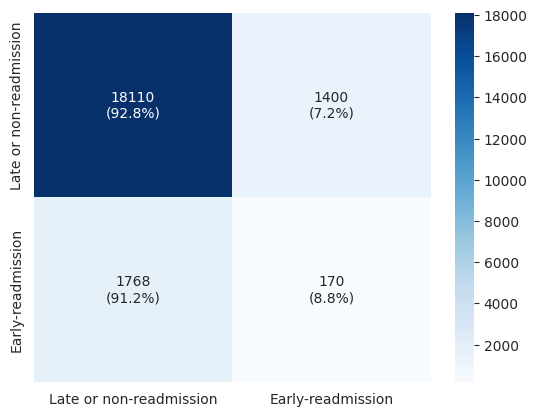

In [95]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [96]:
def objective(trial: optuna.Trial) -> float:
    params = {
        "C": trial.suggest_float("C", 1e-4, 1, log=True),
        "tol": trial.suggest_float("tol", 1e-3, 1e-1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": trial.suggest_int("degree", 2, 5) if trial.params.get("kernel", "") == "poly" else 3,
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        SVC(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [97]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 17:39:33,200] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [27]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-12 16:21:29,347] Trial 5 finished with value: 0.5236109944634141 and parameters: {'C': 0.0787491120012896, 'tol': 0.015748344632062206, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 5 with value: 0.5236109944634141.


Cross validation scores: [0.51875292 0.53340896 0.53105483 0.52012595 0.51471231]
Average score: 0.5236109944634141


[I 2025-01-12 16:21:30,237] Trial 1 finished with value: 0.5266219020053045 and parameters: {'C': 0.07551424361151314, 'tol': 0.00816113222244613, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.5266219020053045.


Cross validation scores: [0.52064849 0.53193267 0.5313877  0.52621812 0.52292253]
Average score: 0.5266219020053045


[I 2025-01-12 16:21:31,180] Trial 6 finished with value: 0.526312802150166 and parameters: {'C': 0.00038841364104974556, 'tol': 0.0025475235680691055, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.5266219020053045.
[I 2025-01-12 16:21:31,363] Trial 10 finished with value: 0.5346051153252903 and parameters: {'C': 0.00022377902432692035, 'tol': 0.0011207893211457637, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 10 with value: 0.5346051153252903.


Cross validation scores: [0.52232891 0.53309768 0.52836023 0.52562936 0.52214783]
Average score: 0.526312802150166
Cross validation scores: [0.5314438  0.54221628 0.53866065 0.53400199 0.52670286]
Average score: 0.5346051153252903


[I 2025-01-12 16:21:33,056] Trial 4 finished with value: 0.543736212096343 and parameters: {'C': 0.14823669283431978, 'tol': 0.020199179082915283, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 4 with value: 0.543736212096343.


Cross validation scores: [0.54825405 0.54759805 0.54731472 0.54055688 0.53495736]
Average score: 0.543736212096343


[I 2025-01-12 16:21:35,397] Trial 7 finished with value: 0.5455201252452315 and parameters: {'C': 0.15206600500069695, 'tol': 0.0013809505933130859, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.54727031 0.54989037 0.54648597 0.54862205 0.53533193]
Average score: 0.5455201252452315


[I 2025-01-12 16:21:39,037] Trial 3 finished with value: 0.43689795583248275 and parameters: {'C': 0.10893378488605766, 'tol': 0.0012831539607691487, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.44495837 0.44091224 0.44193448 0.42204211 0.43464259]
Average score: 0.43689795583248275


[I 2025-01-12 16:21:41,030] Trial 11 finished with value: 0.4732216540677194 and parameters: {'C': 0.03051140690619594, 'tol': 0.0027352077192949057, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.46728687 0.46760141 0.4813933  0.47444567 0.47538102]
Average score: 0.4732216540677194


[I 2025-01-12 16:21:41,628] Trial 13 finished with value: 0.5283055521759408 and parameters: {'C': 0.05427105143078472, 'tol': 0.07766963702595571, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.51710101 0.53503972 0.53876961 0.51803578 0.53258163]
Average score: 0.5283055521759408


[I 2025-01-12 16:21:42,430] Trial 0 finished with value: 0.4527729450847847 and parameters: {'C': 0.0011002285844583643, 'tol': 0.08110559933029426, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.45881851 0.45041591 0.45079908 0.45652862 0.44730262]
Average score: 0.4527729450847847


[I 2025-01-12 16:21:43,023] Trial 9 finished with value: 0.4671263327578118 and parameters: {'C': 0.0006859975546556593, 'tol': 0.09557815290917836, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.47250705 0.47018278 0.46322111 0.46745859 0.46226213]
Average score: 0.4671263327578118


[I 2025-01-12 16:21:44,774] Trial 2 finished with value: 0.5161684843140397 and parameters: {'C': 0.00526595248840388, 'tol': 0.00779679933197332, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.51821995 0.52309102 0.51392113 0.51233448 0.51327583]
Average score: 0.5161684843140397


[I 2025-01-12 16:21:45,249] Trial 8 finished with value: 0.522708902791108 and parameters: {'C': 0.015566691089533704, 'tol': 0.0033782340757296165, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.52234468 0.53150676 0.52482981 0.51661829 0.51824498]
Average score: 0.522708902791108


[I 2025-01-12 16:21:48,118] Trial 16 finished with value: 0.5054891553547172 and parameters: {'C': 0.0002342286675976279, 'tol': 0.01004779770676407, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.50528058 0.50802436 0.50929537 0.50959516 0.49525031]
Average score: 0.5054891553547172


[I 2025-01-12 16:21:49,798] Trial 15 finished with value: 0.4217863755391574 and parameters: {'C': 0.3304834190992409, 'tol': 0.026026959135647364, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.42571415 0.4216041  0.42796387 0.41802908 0.41562068]
Average score: 0.4217863755391574


[I 2025-01-12 16:21:51,817] Trial 19 finished with value: 0.5241291883486437 and parameters: {'C': 0.13562133692395895, 'tol': 0.06573797997308099, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.52283019 0.53197544 0.53047288 0.51602148 0.51934595]
Average score: 0.5241291883486437


[I 2025-01-12 16:21:52,800] Trial 20 finished with value: 0.5231139940712038 and parameters: {'C': 0.023032625658713484, 'tol': 0.03336742783563265, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.52124089 0.53327902 0.52939796 0.51595679 0.51569531]
Average score: 0.5231139940712038


[I 2025-01-12 16:21:53,005] Trial 12 finished with value: 0.45290001469197294 and parameters: {'C': 0.008954446236793825, 'tol': 0.010218161307254696, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.45292549 0.45305753 0.45206512 0.455446   0.45100593]
Average score: 0.45290001469197294


[I 2025-01-12 16:21:55,872] Trial 14 finished with value: 0.5164186117069409 and parameters: {'C': 0.039635902222664096, 'tol': 0.07143209748998147, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.52100837 0.52416742 0.51608777 0.51328555 0.50754395]
Average score: 0.5164186117069409


[I 2025-01-12 16:21:58,969] Trial 17 finished with value: 0.4527729450847847 and parameters: {'C': 0.0009986765609876346, 'tol': 0.02347162700617175, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.45881851 0.45041591 0.45079908 0.45652862 0.44730262]
Average score: 0.4527729450847847


[I 2025-01-12 16:22:00,238] Trial 23 finished with value: 0.5396969396264598 and parameters: {'C': 0.29820567005169957, 'tol': 0.001751834728790278, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.54420879 0.54566708 0.54251702 0.53618597 0.52990583]
Average score: 0.5396969396264598


[I 2025-01-12 16:22:00,551] Trial 24 finished with value: 0.5359074460505071 and parameters: {'C': 0.0024622673828492555, 'tol': 0.005377785213455777, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.53462788 0.54086798 0.54782511 0.53637989 0.51983637]
Average score: 0.5359074460505071


[I 2025-01-12 16:22:01,104] Trial 18 finished with value: 0.4699415828797456 and parameters: {'C': 0.1124371382798626, 'tol': 0.0414188010361517, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.46690105 0.47161914 0.47394172 0.46712316 0.47012283]
Average score: 0.4699415828797456


[I 2025-01-12 16:22:03,147] Trial 25 finished with value: 0.5401785075136283 and parameters: {'C': 0.2894702443863802, 'tol': 0.015385454113905121, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.54460034 0.54595235 0.54357498 0.53628187 0.530483  ]
Average score: 0.5401785075136283


[I 2025-01-12 16:22:03,726] Trial 22 finished with value: 0.5284608373766309 and parameters: {'C': 0.9658462235476231, 'tol': 0.016476052039290857, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.53264924 0.5268857  0.53422592 0.52913084 0.51941248]
Average score: 0.5284608373766309


[I 2025-01-12 16:22:04,704] Trial 21 finished with value: 0.5307982101148506 and parameters: {'C': 0.7634559686478607, 'tol': 0.004601531501978098, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.53363168 0.53391912 0.5328329  0.53408003 0.51952733]
Average score: 0.5307982101148506


[I 2025-01-12 16:22:07,133] Trial 28 finished with value: 0.5362704718099086 and parameters: {'C': 0.0025283959187120198, 'tol': 0.0018647883001228242, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.53468141 0.54118524 0.54732306 0.53616824 0.52199441]
Average score: 0.5362704718099086


[I 2025-01-12 16:22:07,461] Trial 27 finished with value: 0.5054891553547172 and parameters: {'C': 0.00010214655209361753, 'tol': 0.049577158900231406, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.50528058 0.50802436 0.50929537 0.50959516 0.49525031]
Average score: 0.5054891553547172


[I 2025-01-12 16:22:09,452] Trial 29 finished with value: 0.5423036102866614 and parameters: {'C': 0.21585017637372927, 'tol': 0.026391588317250875, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.54606526 0.54744736 0.54311419 0.5449161  0.52997515]
Average score: 0.5423036102866614


[I 2025-01-12 16:22:10,204] Trial 26 finished with value: 0.5354884853914053 and parameters: {'C': 0.46644601185565593, 'tol': 0.0056693499284321035, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.54249151 0.53820503 0.53447934 0.53709702 0.52516953]
Average score: 0.5354884853914053


[I 2025-01-12 16:22:10,799] Trial 30 finished with value: 0.5394953511433995 and parameters: {'C': 0.009412496183904993, 'tol': 0.003874998307022222, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 7 with value: 0.5455201252452315.


Cross validation scores: [0.53871641 0.54454378 0.54922049 0.53949649 0.52549959]
Average score: 0.5394953511433995


[I 2025-01-12 16:22:15,200] Trial 34 finished with value: 0.5471210827934441 and parameters: {'C': 0.05663120332228149, 'tol': 0.0010397162700035445, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.
[I 2025-01-12 16:22:15,378] Trial 31 finished with value: 0.545298338163249 and parameters: {'C': 0.14594630968806815, 'tol': 0.007889388391592424, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54709933 0.5478654  0.55347221 0.5464876  0.54068088]
Average score: 0.5471210827934441
Cross validation scores: [0.54761081 0.54781688 0.54698905 0.54866441 0.53541054]
Average score: 0.545298338163249


[I 2025-01-12 16:22:15,692] Trial 33 finished with value: 0.5418799584653535 and parameters: {'C': 0.2272830677290121, 'tol': 0.001689947331581149, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54565528 0.54558392 0.54515622 0.53919894 0.53380542]
Average score: 0.5418799584653535


[I 2025-01-12 16:22:15,930] Trial 32 finished with value: 0.5356035620729543 and parameters: {'C': 0.49225437342063144, 'tol': 0.0016408329027040817, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54097601 0.54137786 0.53913249 0.53156463 0.52496682]
Average score: 0.5356035620729543


[I 2025-01-12 16:22:18,213] Trial 36 finished with value: 0.5433392253753437 and parameters: {'C': 0.020234553376857256, 'tol': 0.019127183387870894, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54141298 0.54698664 0.55080946 0.54661128 0.53087577]
Average score: 0.5433392253753437


[I 2025-01-12 16:22:21,096] Trial 35 finished with value: 0.5338583904204937 and parameters: {'C': 0.539058572902234, 'tol': 0.013218103464452048, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54180911 0.53327154 0.53532214 0.53391569 0.52497347]
Average score: 0.5338583904204937


[I 2025-01-12 16:22:22,361] Trial 38 finished with value: 0.5431234809757223 and parameters: {'C': 0.1841592914113961, 'tol': 0.006839549767298559, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54758712 0.5460073  0.54633705 0.54009975 0.53558619]
Average score: 0.5431234809757223


[I 2025-01-12 16:22:25,611] Trial 40 finished with value: 0.5461217246915301 and parameters: {'C': 0.036856457211582296, 'tol': 0.02561572630841618, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.55153398 0.55088764 0.5506512  0.54265739 0.53487841]
Average score: 0.5461217246915301


[I 2025-01-12 16:22:26,739] Trial 46 finished with value: 0.5222600493119155 and parameters: {'C': 0.06557011205404611, 'tol': 0.008151521769044967, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.52013219 0.52794043 0.53170263 0.51641129 0.51511371]
Average score: 0.5222600493119155


[I 2025-01-12 16:22:27,402] Trial 37 finished with value: 0.4954229624239794 and parameters: {'C': 0.08588730912274357, 'tol': 0.011711618082852093, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.48787529 0.49562561 0.50279382 0.4973918  0.49342829]
Average score: 0.4954229624239794


[I 2025-01-12 16:22:28,273] Trial 42 finished with value: 0.5399993903515841 and parameters: {'C': 0.3169119771055195, 'tol': 0.013374971857409112, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54786254 0.54339347 0.54094796 0.54163315 0.52615982]
Average score: 0.5399993903515841


[I 2025-01-12 16:22:28,783] Trial 43 finished with value: 0.5469142448538968 and parameters: {'C': 0.058345066029571784, 'tol': 0.001142125804388565, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 34 with value: 0.5471210827934441.


Cross validation scores: [0.54742646 0.54757633 0.55273247 0.54590015 0.54093582]
Average score: 0.5469142448538968


[I 2025-01-12 16:22:29,871] Trial 44 finished with value: 0.5489261496055222 and parameters: {'C': 0.14023418744703328, 'tol': 0.0023714906962207486, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.5497439  0.55235117 0.55197914 0.54823244 0.54232411]
Average score: 0.5489261496055222


[I 2025-01-12 16:22:32,657] Trial 45 finished with value: 0.5434239440652344 and parameters: {'C': 0.05554175442564952, 'tol': 0.0010319117170377425, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.
[I 2025-01-12 16:22:32,844] Trial 39 finished with value: 0.5140773224757786 and parameters: {'C': 0.004448742350703701, 'tol': 0.03490265720954565, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.54294744 0.55181532 0.55082462 0.53996195 0.53157039]
Average score: 0.5434239440652344
Cross validation scores: [0.51684922 0.51929877 0.50987054 0.51158903 0.51277905]
Average score: 0.5140773224757786


[I 2025-01-12 16:22:33,002] Trial 41 finished with value: 0.45677578616265946 and parameters: {'C': 0.012529332368332457, 'tol': 0.021426091743830016, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.45617963 0.45539748 0.45860578 0.46003984 0.4536562 ]
Average score: 0.45677578616265946


[I 2025-01-12 16:22:36,907] Trial 48 finished with value: 0.5437243344566876 and parameters: {'C': 0.03263767744086212, 'tol': 0.002954767896186885, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.54796223 0.54957031 0.54914414 0.53903858 0.53290641]
Average score: 0.5437243344566876


[I 2025-01-12 16:22:38,101] Trial 51 finished with value: 0.5254724968893065 and parameters: {'C': 0.03765187835076207, 'tol': 0.0014095144102989647, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.51849132 0.529682   0.52949404 0.52665064 0.52304449]
Average score: 0.5254724968893065


[I 2025-01-12 16:22:39,187] Trial 47 finished with value: 0.44450148827311453 and parameters: {'C': 0.0924608852527984, 'tol': 0.0013947258016443597, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.45403138 0.45167098 0.44993102 0.42217609 0.44469797]
Average score: 0.44450148827311453


[I 2025-01-12 16:22:40,813] Trial 50 finished with value: 0.536704817869396 and parameters: {'C': 0.006887637383089878, 'tol': 0.05541495987706284, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.53746911 0.5412193  0.54632065 0.5359249  0.52259013]
Average score: 0.536704817869396


[I 2025-01-12 16:22:43,083] Trial 52 finished with value: 0.5399822062027237 and parameters: {'C': 0.021989676252358474, 'tol': 0.03632315108244045, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.54161174 0.54657828 0.54535113 0.54048913 0.52588075]
Average score: 0.5399822062027237


[I 2025-01-12 16:22:43,339] Trial 54 finished with value: 0.5471881093968634 and parameters: {'C': 0.07185169159849172, 'tol': 0.0012232532027602932, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.54750413 0.54938858 0.55304463 0.54547566 0.54052755]
Average score: 0.5471881093968634


[I 2025-01-12 16:22:43,677] Trial 53 finished with value: 0.5454744414489262 and parameters: {'C': 0.0455914565174805, 'tol': 0.029457224356804257, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.54773651 0.55041502 0.54801006 0.54489729 0.53631332]
Average score: 0.5454744414489262


[I 2025-01-12 16:22:44,466] Trial 55 finished with value: 0.5437111096139902 and parameters: {'C': 0.014874349397627077, 'tol': 0.0022496588320457403, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.53961471 0.54565363 0.54902356 0.54790793 0.53635571]
Average score: 0.5437111096139902


[I 2025-01-12 16:22:45,104] Trial 49 finished with value: 0.5048269918964465 and parameters: {'C': 0.1411071204133033, 'tol': 0.0022378802733542696, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.49724585 0.50463293 0.5156007  0.50620236 0.50045313]
Average score: 0.5048269918964465


[I 2025-01-12 16:22:46,524] Trial 57 finished with value: 0.5469909939190832 and parameters: {'C': 0.027921763865383448, 'tol': 0.001250272343969654, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.54405231 0.54730355 0.55655315 0.54856284 0.53848313]
Average score: 0.5469909939190832


[I 2025-01-12 16:22:46,783] Trial 56 finished with value: 0.5474294757900685 and parameters: {'C': 0.09429705407824997, 'tol': 0.0010073041653757963, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.54791291 0.55075084 0.55229692 0.54594723 0.54023947]
Average score: 0.5474294757900685


[I 2025-01-12 16:22:50,825] Trial 61 finished with value: 0.5210306828277552 and parameters: {'C': 0.029210097992816327, 'tol': 0.0011309859404672285, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 44 with value: 0.5489261496055222.


Cross validation scores: [0.51617885 0.52615724 0.52549873 0.51786414 0.51945446]
Average score: 0.5210306828277552


[I 2025-01-12 16:22:51,481] Trial 59 finished with value: 0.5491495548516464 and parameters: {'C': 0.1868353031844304, 'tol': 0.0033569511096466, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 59 with value: 0.5491495548516464.


Cross validation scores: [0.55101312 0.55240915 0.5522003  0.54797028 0.54215494]
Average score: 0.5491495548516464


[I 2025-01-12 16:22:52,301] Trial 60 finished with value: 0.5468066718428586 and parameters: {'C': 0.06089654026205782, 'tol': 0.0014776012830614567, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 59 with value: 0.5491495548516464.


Cross validation scores: [0.5469211  0.54818165 0.5533405  0.54555206 0.54003805]
Average score: 0.5468066718428586


[I 2025-01-12 16:22:55,870] Trial 62 finished with value: 0.548711394119692 and parameters: {'C': 0.12901197993833396, 'tol': 0.0020512961130151174, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 59 with value: 0.5491495548516464.


Cross validation scores: [0.54913421 0.55227753 0.55224892 0.5480872  0.54180911]
Average score: 0.548711394119692


[I 2025-01-12 16:22:57,488] Trial 64 finished with value: 0.5471927594990869 and parameters: {'C': 0.07390942640372512, 'tol': 0.0012133394089664795, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 59 with value: 0.5491495548516464.


Cross validation scores: [0.54757633 0.54917051 0.55297073 0.54594723 0.54029899]
Average score: 0.5471927594990869


[I 2025-01-12 16:22:57,947] Trial 58 finished with value: 0.5082045409016296 and parameters: {'C': 0.0471765687833189, 'tol': 0.0022353097931706828, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 59 with value: 0.5491495548516464.
[I 2025-01-12 16:22:58,102] Trial 65 finished with value: 0.544921858739073 and parameters: {'C': 0.018741240692235435, 'tol': 0.0014233705386535068, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 59 with value: 0.5491495548516464.
[I 2025-01-12 16:22:58,123] Trial 66 finished with value: 0.5469709385912198 and parameters: {'C': 0.07126653749824928, 'tol': 0.0993653508995403, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 59 with value: 0.5491495548516464.


Cross validation scores: [0.51775321 0.51556763 0.50913733 0.49557476 0.50298977]
Average score: 0.5082045409016296
Cross validation scores: [0.53985292 0.5471662  0.55341798 0.54805788 0.53611432]
Average score: 0.544921858739073
Cross validation scores: [0.5458774  0.54987164 0.55289686 0.54568125 0.54052755]
Average score: 0.5469709385912198


[I 2025-01-12 16:22:59,262] Trial 63 finished with value: 0.547404493572694 and parameters: {'C': 0.11526363796062251, 'tol': 0.0028553830470555343, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 59 with value: 0.5491495548516464.


Cross validation scores: [0.54853977 0.55101095 0.54899958 0.55086944 0.53760272]
Average score: 0.547404493572694


[I 2025-01-12 16:23:00,000] Trial 67 finished with value: 0.5491819574000227 and parameters: {'C': 0.23058147706946985, 'tol': 0.0016681262719465857, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.55062846 0.55228985 0.55205283 0.54878371 0.54215494]
Average score: 0.5491819574000227


[I 2025-01-12 16:23:00,615] Trial 68 finished with value: 0.5428779745136547 and parameters: {'C': 0.012411991539846338, 'tol': 0.0013217352213095311, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.53598831 0.54621446 0.54931934 0.54999102 0.53287674]
Average score: 0.5428779745136547


[I 2025-01-12 16:23:05,319] Trial 70 finished with value: 0.5476500276171209 and parameters: {'C': 0.04859237437813273, 'tol': 0.0011646935816165566, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.54786954 0.54682669 0.55410098 0.54885062 0.54060232]
Average score: 0.5476500276171209


[I 2025-01-12 16:23:05,754] Trial 71 finished with value: 0.5452440869086981 and parameters: {'C': 0.028448658671465916, 'tol': 0.003880952009652339, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.54035156 0.54773314 0.55187143 0.5488408  0.53742352]
Average score: 0.5452440869086981


[I 2025-01-12 16:23:06,895] Trial 72 finished with value: 0.5490852844449805 and parameters: {'C': 0.1706779470975777, 'tol': 0.0019561455766209496, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.55072036 0.55267538 0.55190547 0.54797028 0.54215494]
Average score: 0.5490852844449805


[I 2025-01-12 16:23:09,293] Trial 69 finished with value: 0.49744598997246514 and parameters: {'C': 0.09936989554845209, 'tol': 0.0010168452979117208, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.49029628 0.49779109 0.50509046 0.4993452  0.49470692]
Average score: 0.49744598997246514


[I 2025-01-12 16:23:11,424] Trial 74 finished with value: 0.5482841271076634 and parameters: {'C': 0.11640451264463147, 'tol': 0.002544963693068199, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.54884409 0.55142465 0.55210145 0.54740447 0.54164597]
Average score: 0.5482841271076634


[I 2025-01-12 16:23:11,993] Trial 76 finished with value: 0.5471966882353926 and parameters: {'C': 0.0764385470208812, 'tol': 0.002073065007507569, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.54832647 0.54936214 0.553089   0.54551679 0.53968904]
Average score: 0.5471966882353926


[I 2025-01-12 16:23:12,578] Trial 73 finished with value: 0.5489666430423118 and parameters: {'C': 0.4208266549993128, 'tol': 0.0019435889202593704, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.55043536 0.5518755  0.55126777 0.54905002 0.54220457]
Average score: 0.5489666430423118


[I 2025-01-12 16:23:13,018] Trial 78 finished with value: 0.5482275135498196 and parameters: {'C': 0.1141246434257837, 'tol': 0.0026779463323461945, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 67 with value: 0.5491819574000227.


Cross validation scores: [0.54884409 0.55142465 0.55210145 0.54733216 0.54143521]
Average score: 0.5482275135498196


[I 2025-01-12 16:23:15,173] Trial 79 finished with value: 0.5491936974162192 and parameters: {'C': 0.2246957920339449, 'tol': 0.0037305263093866535, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 79 with value: 0.5491936974162192.


Cross validation scores: [0.55062846 0.55221617 0.55205283 0.54891609 0.54215494]
Average score: 0.5491936974162192


[I 2025-01-12 16:23:15,950] Trial 81 finished with value: 0.5270440833293728 and parameters: {'C': 0.37059388439879515, 'tol': 0.0016238308447262158, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 79 with value: 0.5491936974162192.


Cross validation scores: [0.52032909 0.52990644 0.53484367 0.52456373 0.52557748]
Average score: 0.5270440833293728


[I 2025-01-12 16:23:16,419] Trial 75 finished with value: 0.5437152724607455 and parameters: {'C': 0.7323387645832911, 'tol': 0.003232630440085808, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 79 with value: 0.5491936974162192.


Cross validation scores: [0.55002273 0.55209632 0.55195409 0.53428198 0.53022124]
Average score: 0.5437152724607455


[I 2025-01-12 16:23:16,733] Trial 80 finished with value: 0.5337109293308335 and parameters: {'C': 0.6712129678083876, 'tol': 0.0045712225071230135, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 79 with value: 0.5491936974162192.
[I 2025-01-12 16:23:16,897] Trial 77 finished with value: 0.4225559127510669 and parameters: {'C': 0.18018787151438617, 'tol': 0.0015253278999320344, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 79 with value: 0.5491936974162192.


Cross validation scores: [0.53732181 0.53891431 0.53699131 0.53118259 0.52414463]
Average score: 0.5337109293308335
Cross validation scores: [0.42713793 0.42214067 0.425915   0.42331262 0.41427335]
Average score: 0.4225559127510669


[I 2025-01-12 16:23:20,966] Trial 82 finished with value: 0.549365171743299 and parameters: {'C': 0.2892312363930828, 'tol': 0.002484858003984543, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.5505816  0.55228985 0.55205283 0.54974664 0.54215494]
Average score: 0.549365171743299


[I 2025-01-12 16:23:21,493] Trial 83 finished with value: 0.5489978252037272 and parameters: {'C': 0.16659036093121393, 'tol': 0.0018508349125423474, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55050105 0.55252786 0.55190547 0.54797028 0.54208447]
Average score: 0.5489978252037272


[I 2025-01-12 16:23:25,377] Trial 84 finished with value: 0.5491965389119693 and parameters: {'C': 0.2409190182675372, 'tol': 0.003197927310576901, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55062846 0.55228985 0.55205283 0.54885662 0.54215494]
Average score: 0.5491965389119693


[I 2025-01-12 16:23:26,002] Trial 85 finished with value: 0.5487861616040043 and parameters: {'C': 0.13324832137259915, 'tol': 0.0024137457342358025, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.54942472 0.55227753 0.55190547 0.54823244 0.54209066]
Average score: 0.5487861616040043


[I 2025-01-12 16:23:26,828] Trial 86 finished with value: 0.5492164341244994 and parameters: {'C': 0.2127898299598125, 'tol': 0.0020035107482080615, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55055532 0.55221617 0.55212655 0.54869744 0.54248668]
Average score: 0.5492164341244994


[I 2025-01-12 16:23:29,354] Trial 87 finished with value: 0.5489436971806168 and parameters: {'C': 0.38340780762257115, 'tol': 0.001995050614757494, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.5505816  0.5518755  0.55126777 0.54905002 0.5419436 ]
Average score: 0.5489436971806168


[I 2025-01-12 16:23:30,882] Trial 92 finished with value: 0.5485217150273498 and parameters: {'C': 0.12402645533015327, 'tol': 0.0026583489450320527, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.54913421 0.55186526 0.55224892 0.54736253 0.54199766]
Average score: 0.5485217150273498


[I 2025-01-12 16:23:31,580] Trial 91 finished with value: 0.549357389535569 and parameters: {'C': 0.26516879896235346, 'tol': 0.005683762565838331, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55077479 0.55228985 0.55212655 0.54944081 0.54215494]
Average score: 0.549357389535569


[I 2025-01-12 16:23:32,018] Trial 93 finished with value: 0.5492358108634081 and parameters: {'C': 0.194250946282692, 'tol': 0.0018277299461298057, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55082104 0.55255662 0.55212655 0.54818816 0.54248668]
Average score: 0.5492358108634081


[I 2025-01-12 16:23:33,279] Trial 89 finished with value: 0.5438256856237549 and parameters: {'C': 0.9988677147405204, 'tol': 0.0036256802348855763, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55016872 0.55209632 0.55195409 0.5344865  0.53042279]
Average score: 0.5438256856237549


[I 2025-01-12 16:23:33,613] Trial 88 finished with value: 0.5057942217244232 and parameters: {'C': 0.467325283063032, 'tol': 0.002735706360987836, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.
[I 2025-01-12 16:23:33,736] Trial 90 finished with value: 0.5460993835144639 and parameters: {'C': 0.5877106834318072, 'tol': 0.0043430526135452095, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.49890624 0.50365404 0.51602187 0.50824135 0.50214761]
Average score: 0.5057942217244232
Cross validation scores: [0.55016872 0.55194908 0.55195409 0.53774274 0.53868228]
Average score: 0.5460993835144639


[I 2025-01-12 16:23:34,802] Trial 95 finished with value: 0.5490761445050593 and parameters: {'C': 0.1774848335075189, 'tol': 0.001831490607390377, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55079351 0.55233544 0.55212655 0.54797028 0.54215494]
Average score: 0.5490761445050593


[I 2025-01-12 16:23:35,927] Trial 94 finished with value: 0.5489003687797593 and parameters: {'C': 0.40329713124737626, 'tol': 0.0024261279011919146, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55043536 0.5518755  0.55126777 0.54905002 0.5418732 ]
Average score: 0.5489003687797593


[I 2025-01-12 16:23:38,026] Trial 96 finished with value: 0.5493452441565878 and parameters: {'C': 0.2674486031444343, 'tol': 0.00319138876957878, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55077479 0.55228985 0.55205283 0.54945381 0.54215494]
Average score: 0.5493452441565878


[I 2025-01-12 16:23:38,494] Trial 98 finished with value: 0.5391950058494982 and parameters: {'C': 0.3103407915050087, 'tol': 0.003046051010061814, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.54353472 0.54548721 0.54181423 0.53552749 0.52961139]
Average score: 0.5391950058494982


[I 2025-01-12 16:23:39,746] Trial 99 finished with value: 0.5492698395360116 and parameters: {'C': 0.20849036366280357, 'tol': 0.0035920221735564646, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.55089424 0.55221617 0.5522003  0.5485518  0.54248668]
Average score: 0.5492698395360116


[I 2025-01-12 16:23:40,413] Trial 97 finished with value: 0.41689180566578843 and parameters: {'C': 0.25344374285308185, 'tol': 0.005178186762031322, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 82 with value: 0.549365171743299.


Cross validation scores: [0.42166644 0.413779   0.41953159 0.4221506  0.4073314 ]
Average score: 0.41689180566578843


In [28]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 82
Best Parameters: {'C': 0.2892312363930828, 'tol': 0.002484858003984543, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}
Best Value: 0.549365171743299


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [98]:
optuna.visualization.plot_optimization_history(study)

In [99]:
optuna.visualization.plot_slice(study)

In [100]:
optuna.visualization.plot_param_importances(study)

In [101]:
optuna.visualization.plot_parallel_coordinate(study)

In [102]:
optuna.visualization.plot_contour(study)

In [103]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [104]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    SVC(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('svc',
                 SVC(C=0.2892312363930828, degree=2, kernel='poly',
                     random_state=38, tol=0.002484858003984543))])

In [105]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [106]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.7803376960735339
Test accuracy:  0.774757553151809


In [107]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.82      0.87     19510
      Early-readmission       0.16      0.34      0.21      1938

               accuracy                           0.77     21448
              macro avg       0.54      0.58      0.54     21448
           weighted avg       0.86      0.77      0.81     21448



In [108]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

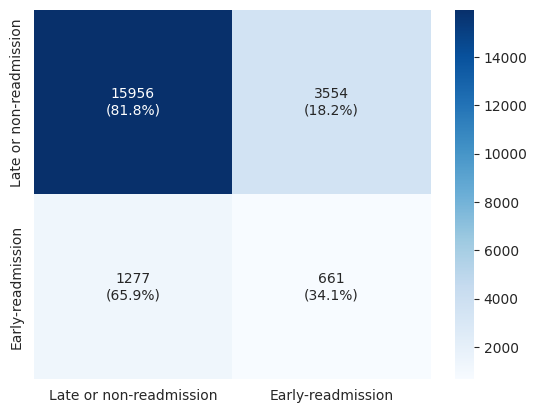

In [109]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [110]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "C": trial.suggest_float("C", 1e-4, 1, log=True),
        "tol": trial.suggest_float("tol", 1e-4, 1e-2, log=True),
        "penalty": "l2",
        "loss": trial.suggest_categorical("loss", ["hinge", "squared_hinge"]),
        "dual": True
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        LinearSVC(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [111]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 17:39:43,378] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [44]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-12 17:21:25,443] Trial 7 finished with value: 0.5131401634547347 and parameters: {'C': 0.0004567280254992059, 'tol': 0.0008061331458489757, 'loss': 'hinge'}. Best is trial 7 with value: 0.5131401634547347.


Cross validation scores: [0.51318155 0.51484802 0.51653337 0.51274769 0.50839019]
Average score: 0.5131401634547347


[I 2025-01-12 17:21:25,720] Trial 9 finished with value: 0.5259643809710168 and parameters: {'C': 0.003147125263249692, 'tol': 0.00043085465968758916, 'loss': 'hinge'}. Best is trial 9 with value: 0.5259643809710168.
[I 2025-01-12 17:21:25,739] Trial 1 finished with value: 0.5021836404216066 and parameters: {'C': 0.00048262998503675804, 'tol': 0.0005007700873702097, 'loss': 'squared_hinge'}. Best is trial 9 with value: 0.5259643809710168.
[I 2025-01-12 17:21:25,769] Trial 11 finished with value: 0.5022012510367682 and parameters: {'C': 0.0004724829553623123, 'tol': 0.004810518861783297, 'loss': 'squared_hinge'}. Best is trial 9 with value: 0.5259643809710168.
[I 2025-01-12 17:21:25,817] Trial 8 finished with value: 0.5254928678308524 and parameters: {'C': 0.0011358395916125385, 'tol': 0.00511488462954396, 'loss': 'hinge'}. Best is trial 9 with value: 0.5259643809710168.
[I 2025-01-12 17:21:25,819] Trial 3 finished with value: 0.5254997752999561 and parameters: {'C': 0.00319207454754774

Cross validation scores: [0.51783807 0.52715453 0.5442074  0.51672588 0.52389602]
Average score: 0.5259643809710168
Cross validation scores: [0.50479981 0.50269394 0.50796734 0.50004989 0.49540723]
Average score: 0.5021836404216066
Cross validation scores: [0.50467089 0.50305817 0.50796734 0.50002874 0.49528112]
Average score: 0.5022012510367682
Cross validation scores: [0.51717432 0.52637069 0.54089988 0.51929752 0.52375646]
Average score: 0.5254997752999561
Cross validation scores: [0.52196746 0.53220679 0.53192523 0.52130493 0.52005993]
Average score: 0.5254928678308524


[I 2025-01-12 17:21:26,140] Trial 5 finished with value: 0.5048467809774565 and parameters: {'C': 0.009628819307005225, 'tol': 0.008071788886285295, 'loss': 'squared_hinge'}. Best is trial 9 with value: 0.5259643809710168.


Cross validation scores: [0.50667007 0.50611208 0.50866484 0.50432492 0.498462  ]
Average score: 0.5048467809774565


[I 2025-01-12 17:21:27,686] Trial 15 finished with value: 0.524846559287508 and parameters: {'C': 0.000851401297425765, 'tol': 0.0067677896296029815, 'loss': 'hinge'}. Best is trial 9 with value: 0.5259643809710168.


Cross validation scores: [0.52177194 0.53029352 0.53164739 0.52130493 0.51921502]
Average score: 0.524846559287508


[I 2025-01-12 17:21:28,581] Trial 0 finished with value: 0.5253291245332281 and parameters: {'C': 0.046839750688682825, 'tol': 0.00041884202294707013, 'loss': 'hinge'}. Best is trial 9 with value: 0.5259643809710168.
[I 2025-01-12 17:21:28,717] Trial 17 finished with value: 0.5046460343154483 and parameters: {'C': 0.005000296503217268, 'tol': 0.0020221457324022065, 'loss': 'squared_hinge'}. Best is trial 9 with value: 0.5259643809710168.


Cross validation scores: [0.52379864 0.53138694 0.52828769 0.52213096 0.52104138]
Average score: 0.5253291245332281
Cross validation scores: [0.50660548 0.50578877 0.5087078  0.50387677 0.49825135]
Average score: 0.5046460343154483
Cross validation scores: [0.50691806 0.50553025 0.50840442 0.50330111 0.49780808]
Average score: 0.504392383455184


[I 2025-01-12 17:21:28,792] Trial 18 finished with value: 0.504392383455184 and parameters: {'C': 0.0019409091060226355, 'tol': 0.00018178243034872618, 'loss': 'squared_hinge'}. Best is trial 9 with value: 0.5259643809710168.
[I 2025-01-12 17:21:29,406] Trial 12 finished with value: 0.5288813153873198 and parameters: {'C': 0.030247937087493567, 'tol': 0.00044790978614171544, 'loss': 'hinge'}. Best is trial 12 with value: 0.5288813153873198.


Cross validation scores: [0.51611374 0.54016748 0.53916851 0.52220762 0.52674922]
Average score: 0.5288813153873198


[I 2025-01-12 17:21:29,814] Trial 19 finished with value: 0.5216326652515251 and parameters: {'C': 0.0006521655342920997, 'tol': 0.00023625261532613496, 'loss': 'hinge'}. Best is trial 12 with value: 0.5288813153873198.
[I 2025-01-12 17:21:30,010] Trial 14 finished with value: 0.5049209853399292 and parameters: {'C': 0.025492797624397705, 'tol': 0.00766924209540803, 'loss': 'squared_hinge'}. Best is trial 12 with value: 0.5288813153873198.


Cross validation scores: [0.51894487 0.52375798 0.52828885 0.51986341 0.51730821]
Average score: 0.5216326652515251
Cross validation scores: [0.50656537 0.50607482 0.50892369 0.50438897 0.49865208]
Average score: 0.5049209853399292


[I 2025-01-12 17:21:30,574] Trial 21 finished with value: 0.49191816474264505 and parameters: {'C': 0.00018183648465467983, 'tol': 0.00010858212685567093, 'loss': 'hinge'}. Best is trial 12 with value: 0.5288813153873198.
[I 2025-01-12 17:21:30,729] Trial 20 finished with value: 0.5038398788248768 and parameters: {'C': 0.0010519482994934808, 'tol': 0.008261942975812285, 'loss': 'squared_hinge'}. Best is trial 12 with value: 0.5288813153873198.


Cross validation scores: [0.49521471 0.4915317  0.49595952 0.49120145 0.48568344]
Average score: 0.49191816474264505
Cross validation scores: [0.50676304 0.50465406 0.50771564 0.50234297 0.49772367]
Average score: 0.5038398788248768


[I 2025-01-12 17:21:30,885] Trial 22 finished with value: 0.5220547743828582 and parameters: {'C': 0.0034723433166804936, 'tol': 0.0008228378918472354, 'loss': 'hinge'}. Best is trial 12 with value: 0.5288813153873198.
[I 2025-01-12 17:21:30,961] Trial 13 finished with value: 0.5049209853399292 and parameters: {'C': 0.027564226776926423, 'tol': 0.0014723395785756089, 'loss': 'squared_hinge'}. Best is trial 12 with value: 0.5288813153873198.


Cross validation scores: [0.51689568 0.53677529 0.52637737 0.5160864  0.51413913]
Average score: 0.5220547743828582
Cross validation scores: [0.50656537 0.50607482 0.50892369 0.50438897 0.49865208]
Average score: 0.5049209853399292


[I 2025-01-12 17:21:31,123] Trial 16 finished with value: 0.5049468796821582 and parameters: {'C': 0.034874134178206756, 'tol': 0.00568004689040354, 'loss': 'squared_hinge'}. Best is trial 12 with value: 0.5288813153873198.


Cross validation scores: [0.50656537 0.50607482 0.50905316 0.50438897 0.49865208]
Average score: 0.5049468796821582


[I 2025-01-12 17:21:32,344] Trial 26 finished with value: 0.48161362142709485 and parameters: {'C': 0.00011664310732465623, 'tol': 0.0005984520565178803, 'loss': 'hinge'}. Best is trial 12 with value: 0.5288813153873198.


Cross validation scores: [0.48345187 0.48403671 0.4826098  0.48370135 0.47426838]
Average score: 0.48161362142709485


[I 2025-01-12 17:21:32,862] Trial 25 finished with value: 0.5231053042748792 and parameters: {'C': 0.010804696763383461, 'tol': 0.00013008782274016292, 'loss': 'hinge'}. Best is trial 12 with value: 0.5288813153873198.
[I 2025-01-12 17:21:32,898] Trial 24 finished with value: 0.5317185908876426 and parameters: {'C': 0.011811018963783044, 'tol': 0.0002784826459351554, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51914135 0.52693852 0.52588019 0.52116273 0.52240374]
Average score: 0.5231053042748792
Cross validation scores: [0.53356435 0.53465513 0.53625011 0.52427759 0.52984577]
Average score: 0.5317185908876426


[I 2025-01-12 17:21:33,437] Trial 30 finished with value: 0.525992372474491 and parameters: {'C': 0.006255275134701402, 'tol': 0.0006062617969318638, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51979138 0.54059073 0.53824898 0.51680092 0.51452985]
Average score: 0.525992372474491


[I 2025-01-12 17:21:33,790] Trial 29 finished with value: 0.5271649732568292 and parameters: {'C': 0.014676675439656797, 'tol': 0.0010758167270862693, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52645951 0.53622525 0.52574643 0.52490725 0.52248642]
Average score: 0.5271649732568292


[I 2025-01-12 17:21:34,873] Trial 32 finished with value: 0.5255065089470309 and parameters: {'C': 0.0021423499501327893, 'tol': 0.0032621193275619, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51879619 0.53706092 0.53657617 0.51784252 0.51725674]
Average score: 0.5255065089470309


[I 2025-01-12 17:21:35,512] Trial 34 finished with value: 0.5250327733460638 and parameters: {'C': 0.00614406371482464, 'tol': 0.0005676390713657578, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.5175658  0.53110521 0.53449757 0.52284687 0.51914841]
Average score: 0.5250327733460638


[I 2025-01-12 17:21:35,954] Trial 33 finished with value: 0.5299420318182102 and parameters: {'C': 0.016388544185333767, 'tol': 0.0002788673425758585, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.53398124 0.53492609 0.5324548  0.5192039  0.52914412]
Average score: 0.5299420318182102


[I 2025-01-12 17:21:36,865] Trial 35 finished with value: 0.5305736228203329 and parameters: {'C': 0.01491236666026915, 'tol': 0.0013038013348536813, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.53270226 0.53870038 0.53554426 0.52076831 0.52515291]
Average score: 0.5305736228203329


[I 2025-01-12 17:21:39,106] Trial 28 finished with value: 0.5278222572799951 and parameters: {'C': 0.07504855343988767, 'tol': 0.00017403762302189082, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.
[I 2025-01-12 17:21:39,190] Trial 23 finished with value: 0.5282809513346873 and parameters: {'C': 0.08477588884052062, 'tol': 0.00044225159295499636, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.
[I 2025-01-12 17:21:39,288] Trial 31 finished with value: 0.5281809729422464 and parameters: {'C': 0.06924518351000801, 'tol': 0.00034312754152905574, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51761376 0.54078819 0.53678763 0.51692557 0.52699614]
Average score: 0.5278222572799951
Cross validation scores: [0.51882153 0.54169464 0.53941278 0.52172081 0.51975501]
Average score: 0.5282809513346873
Cross validation scores: [0.53374994 0.52730813 0.54104724 0.51602169 0.52277786]
Average score: 0.5281809729422464


[I 2025-01-12 17:21:40,201] Trial 39 finished with value: 0.5267740649153007 and parameters: {'C': 0.0162593071066436, 'tol': 0.0007077741543225586, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52761066 0.53179647 0.53254651 0.51882041 0.52309627]
Average score: 0.5267740649153007


[I 2025-01-12 17:21:41,629] Trial 40 finished with value: 0.5265130585546963 and parameters: {'C': 0.009675376867162602, 'tol': 0.0013048457852334347, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.5219712  0.54007633 0.53051293 0.52741088 0.51259396]
Average score: 0.5265130585546963


[I 2025-01-12 17:21:41,860] Trial 36 finished with value: 0.5276176774461924 and parameters: {'C': 0.054931114575095086, 'tol': 0.0010096633139089473, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.
[I 2025-01-12 17:21:41,959] Trial 10 finished with value: 0.5048793500459677 and parameters: {'C': 0.14879057859667846, 'tol': 0.0017606083937255982, 'loss': 'squared_hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52808436 0.54027403 0.52799508 0.52539195 0.51634298]
Average score: 0.5276176774461924
Cross validation scores: [0.50633138 0.50607482 0.50918266 0.50438897 0.49841892]
Average score: 0.5048793500459677


[I 2025-01-12 17:21:42,708] Trial 41 finished with value: 0.5265531461007568 and parameters: {'C': 0.017295369952828966, 'tol': 0.002271348142698147, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52515246 0.52717407 0.52726578 0.52417598 0.52899744]
Average score: 0.5265531461007568


[I 2025-01-12 17:21:44,071] Trial 43 finished with value: 0.522745685690524 and parameters: {'C': 0.022446417974288476, 'tol': 0.00037467497653178417, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52006173 0.53559682 0.52888964 0.51627627 0.51290396]
Average score: 0.522745685690524


[I 2025-01-12 17:21:44,320] Trial 45 finished with value: 0.5285975877227802 and parameters: {'C': 0.008362581750449686, 'tol': 0.00018131899628639936, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52435409 0.53597668 0.53828588 0.52124995 0.52312133]
Average score: 0.5285975877227802


[I 2025-01-12 17:21:44,612] Trial 42 finished with value: 0.5309249241374879 and parameters: {'C': 0.04216278612439097, 'tol': 0.00025757191937654723, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52296399 0.54005026 0.52835006 0.53317563 0.53008468]
Average score: 0.5309249241374879


[I 2025-01-12 17:21:45,076] Trial 47 finished with value: 0.5236809736831517 and parameters: {'C': 0.0034285032951602962, 'tol': 0.0002782838270502686, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51722193 0.52949964 0.52931278 0.5282266  0.51414391]
Average score: 0.5236809736831517


[I 2025-01-12 17:21:47,007] Trial 46 finished with value: 0.5245599675177551 and parameters: {'C': 0.03562313047169583, 'tol': 0.00014346839536170705, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52402309 0.54045564 0.52557482 0.51984232 0.51290396]
Average score: 0.5245599675177551


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:21:47,376] Trial 48 finished with value: 0.5224041317299415 and parameters: {'C': 0.013325944185411326, 'tol': 0.0007575288186334415, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52283128 0.52531378 0.52681778 0.51941468 0.51764313]
Average score: 0.5224041317299415


[I 2025-01-12 17:21:47,744] Trial 6 finished with value: 0.5048922825025545 and parameters: {'C': 0.22043475692469117, 'tol': 0.0077830130213697385, 'loss': 'squared_hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.50633138 0.50613948 0.50918266 0.50438897 0.49841892]
Average score: 0.5048922825025545


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:21:49,254] Trial 37 finished with value: 0.529733595660014 and parameters: {'C': 0.15085617214351524, 'tol': 0.00021394203205047017, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.53484105 0.53179709 0.52862732 0.52654623 0.52685629]
Average score: 0.529733595660014


[I 2025-01-12 17:21:49,655] Trial 51 finished with value: 0.5049081753008293 and parameters: {'C': 0.021492091552462407, 'tol': 0.003734081882569889, 'loss': 'squared_hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.50656537 0.50607482 0.50892369 0.50432492 0.49865208]
Average score: 0.5049081753008293


[I 2025-01-12 17:21:50,008] Trial 54 finished with value: 0.5236960935127489 and parameters: {'C': 0.004637590499255276, 'tol': 0.00020694794093725562, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51869185 0.52577521 0.535824   0.52430883 0.51388057]
Average score: 0.5236960935127489


[I 2025-01-12 17:21:50,524] Trial 50 finished with value: 0.5297080990989848 and parameters: {'C': 0.049093008264437354, 'tol': 0.0002391599809518595, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.53819121 0.53623046 0.53533623 0.52360608 0.51517652]
Average score: 0.5297080990989848


[I 2025-01-12 17:21:51,556] Trial 52 finished with value: 0.5277660071623914 and parameters: {'C': 0.030702365649258875, 'tol': 0.0004013497593870869, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52103475 0.53294954 0.53552503 0.52321049 0.52611023]
Average score: 0.5277660071623914


[I 2025-01-12 17:21:52,577] Trial 53 finished with value: 0.5247470067262305 and parameters: {'C': 0.041805895957667295, 'tol': 0.00026351704203579645, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.53182048 0.52821793 0.52591789 0.52298963 0.51478911]
Average score: 0.5247470067262305


[I 2025-01-12 17:21:52,938] Trial 4 finished with value: 0.5048922825025545 and parameters: {'C': 0.2703406186960712, 'tol': 0.0029065221519195923, 'loss': 'squared_hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.50633138 0.50613948 0.50918266 0.50438897 0.49841892]
Average score: 0.5048922825025545


[I 2025-01-12 17:21:53,246] Trial 44 finished with value: 0.5276629283624236 and parameters: {'C': 0.11059646169838393, 'tol': 0.0004673031974699012, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52227578 0.53417103 0.53017277 0.52339316 0.52830191]
Average score: 0.5276629283624236


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:21:56,398] Trial 61 finished with value: 0.5047060793132777 and parameters: {'C': 0.008184085676105271, 'tol': 0.0008826222007560212, 'loss': 'squared_hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.50667007 0.50598273 0.50860015 0.50406879 0.49820866]
Average score: 0.5047060793132777


[I 2025-01-12 17:21:58,299] Trial 59 finished with value: 0.5289169395555688 and parameters: {'C': 0.05486830433459729, 'tol': 0.0018035814207472058, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51677499 0.52588991 0.54027403 0.53369637 0.52794939]
Average score: 0.5289169395555688


[I 2025-01-12 17:21:59,334] Trial 62 finished with value: 0.5301919961402295 and parameters: {'C': 0.04233827816162195, 'tol': 0.00023954193777990924, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.5246005  0.53328976 0.5361139  0.52690864 0.53004717]
Average score: 0.5301919961402295


[I 2025-01-12 17:21:59,704] Trial 63 finished with value: 0.5226335549690089 and parameters: {'C': 0.01996926828485467, 'tol': 0.00031496056862914104, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51611374 0.53274958 0.5258133  0.52383442 0.51465673]
Average score: 0.5226335549690089


[I 2025-01-12 17:22:01,178] Trial 64 finished with value: 0.5244158516484003 and parameters: {'C': 0.011802575717544386, 'tol': 0.0005305967551896696, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51630909 0.53293029 0.53192343 0.51556119 0.52535526]
Average score: 0.5244158516484003


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:02,213] Trial 58 finished with value: 0.5276867295543703 and parameters: {'C': 0.11731392841891806, 'tol': 0.00010707727017708289, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.53384553 0.5252316  0.53144014 0.52201908 0.5258973 ]
Average score: 0.5276867295543703


[I 2025-01-12 17:22:03,544] Trial 60 finished with value: 0.5285626765964045 and parameters: {'C': 0.11186626758552537, 'tol': 0.00021212004697386503, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.
[I 2025-01-12 17:22:03,693] Trial 65 finished with value: 0.5293274557823295 and parameters: {'C': 0.029350649715384747, 'tol': 0.0001519916776337757, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52575665 0.52600914 0.54021067 0.52551778 0.52531914]
Average score: 0.5285626765964045
Cross validation scores: [0.52925887 0.53564522 0.53437146 0.51595657 0.53140516]
Average score: 0.5293274557823295


[I 2025-01-12 17:22:05,711] Trial 70 finished with value: 0.5256170149177157 and parameters: {'C': 0.0016590362781388277, 'tol': 0.001581756685733858, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52256703 0.53321686 0.52594708 0.51994428 0.52640981]
Average score: 0.5256170149177157


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:06,770] Trial 55 finished with value: 0.5272440997611356 and parameters: {'C': 0.1776018360382352, 'tol': 0.00013660246201052922, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51993474 0.53240121 0.53583833 0.52890769 0.51913853]
Average score: 0.5272440997611356


[I 2025-01-12 17:22:07,326] Trial 38 finished with value: 0.5273732924782808 and parameters: {'C': 0.42930263667767793, 'tol': 0.0003015746164249735, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52446808 0.53408325 0.53849288 0.52140489 0.51841738]
Average score: 0.5273732924782808


[I 2025-01-12 17:22:07,742] Trial 49 finished with value: 0.5254808800788384 and parameters: {'C': 0.23813659850646582, 'tol': 0.0011765617539201444, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51580296 0.538456   0.52748542 0.521682   0.52397802]
Average score: 0.5254808800788384


[I 2025-01-12 17:22:08,675] Trial 71 finished with value: 0.504680229425043 and parameters: {'C': 0.006931148437437494, 'tol': 0.0006491307246471329, 'loss': 'squared_hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.50660548 0.50591807 0.50860015 0.50406879 0.49820866]
Average score: 0.504680229425043


[I 2025-01-12 17:22:08,904] Trial 67 finished with value: 0.5287193998693981 and parameters: {'C': 0.06516393061324291, 'tol': 0.0003679795274127527, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52858307 0.53613639 0.53619249 0.5217421  0.52094295]
Average score: 0.5287193998693981


[I 2025-01-12 17:22:09,308] Trial 69 finished with value: 0.5239168115070332 and parameters: {'C': 0.04103665989207827, 'tol': 0.00027151531311654984, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51993565 0.53071283 0.53845495 0.51751214 0.51296848]
Average score: 0.5239168115070332


[I 2025-01-12 17:22:10,726] Trial 72 finished with value: 0.5216923656850381 and parameters: {'C': 0.023996828747562746, 'tol': 0.0002582371425156816, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.51618402 0.52668553 0.52639464 0.51602148 0.52317617]
Average score: 0.5216923656850381


[I 2025-01-12 17:22:11,460] Trial 77 finished with value: 0.5237484469682773 and parameters: {'C': 0.004478966501818338, 'tol': 0.0004156519255106564, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.
[I 2025-01-12 17:22:11,551] Trial 74 finished with value: 0.5239810024543605 and parameters: {'C': 0.017252513565357813, 'tol': 0.00034155399699793124, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52216829 0.5317306  0.5265201  0.52535159 0.51297166]
Average score: 0.5237484469682773
Cross validation scores: [0.52341368 0.53493916 0.52809431 0.51920069 0.51425718]
Average score: 0.5239810024543605


[I 2025-01-12 17:22:12,458] Trial 68 finished with value: 0.5225912191213872 and parameters: {'C': 0.09341166474247149, 'tol': 0.0001194694173699566, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52037067 0.52495573 0.52675942 0.51595657 0.5249137 ]
Average score: 0.5225912191213872


[I 2025-01-12 17:22:13,590] Trial 73 finished with value: 0.5288173232344751 and parameters: {'C': 0.04825157820269664, 'tol': 0.00023593557786420942, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.
[I 2025-01-12 17:22:13,686] Trial 78 finished with value: 0.5256400237198356 and parameters: {'C': 0.012239228296370312, 'tol': 0.00048248716125941, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52807041 0.53281759 0.52748267 0.52777535 0.5279406 ]
Average score: 0.5288173232344751
Cross validation scores: [0.52521729 0.53105105 0.52660356 0.52157777 0.52375044]
Average score: 0.5256400237198356


[I 2025-01-12 17:22:14,957] Trial 81 finished with value: 0.5253380698421047 and parameters: {'C': 0.015171850385502065, 'tol': 0.009429000252893721, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52473052 0.54066149 0.5312568  0.51718919 0.51285235]
Average score: 0.5253380698421047


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:15,533] Trial 57 finished with value: 0.5048793500459677 and parameters: {'C': 0.15162392853718248, 'tol': 0.00016301973985896587, 'loss': 'squared_hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.50633138 0.50607482 0.50918266 0.50438897 0.49841892]
Average score: 0.5048793500459677


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:15,808] Trial 27 finished with value: 0.5288791211695543 and parameters: {'C': 0.9127022192677791, 'tol': 0.00031748264048042456, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.
[I 2025-01-12 17:22:15,868] Trial 75 finished with value: 0.5283423947398805 and parameters: {'C': 0.056242625852676496, 'tol': 0.00019050129590065043, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.53014668 0.53731159 0.5256992  0.52323782 0.52800032]
Average score: 0.5288791211695543
Cross validation scores: [0.51868826 0.53962086 0.53566538 0.52661442 0.52112305]
Average score: 0.5283423947398805


[I 2025-01-12 17:22:16,366] Trial 80 finished with value: 0.5278726196573744 and parameters: {'C': 0.03575593839817696, 'tol': 0.00016195520968334467, 'loss': 'hinge'}. Best is trial 24 with value: 0.5317185908876426.


Cross validation scores: [0.52633447 0.541096   0.53972876 0.51595657 0.5162473 ]
Average score: 0.5278726196573744


[I 2025-01-12 17:22:17,726] Trial 56 finished with value: 0.532983773395072 and parameters: {'C': 0.35169937535482815, 'tol': 0.0002314067197653275, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53274879 0.54058131 0.54044197 0.52312936 0.52801744]
Average score: 0.532983773395072


[I 2025-01-12 17:22:18,070] Trial 82 finished with value: 0.5237121529516118 and parameters: {'C': 0.027717636535621308, 'tol': 0.00015282474298092312, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.51673486 0.52584215 0.53893953 0.52381756 0.51322666]
Average score: 0.5237121529516118


[I 2025-01-12 17:22:19,032] Trial 85 finished with value: 0.5251802966449375 and parameters: {'C': 0.019162361144983327, 'tol': 0.0002562667161275248, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.
[I 2025-01-12 17:22:19,033] Trial 88 finished with value: 0.5259057208812703 and parameters: {'C': 0.010061521814189265, 'tol': 0.00010279928671685675, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.51611374 0.53581837 0.53985319 0.51595657 0.51815962]
Average score: 0.5251802966449375
Cross validation scores: [0.52369165 0.53183497 0.52761691 0.51619639 0.53018869]
Average score: 0.5259057208812703


[I 2025-01-12 17:22:19,466] Trial 84 finished with value: 0.5262350712375369 and parameters: {'C': 0.03351042889857992, 'tol': 0.00022318457251035908, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.51645359 0.52832608 0.53880586 0.51777127 0.52981855]
Average score: 0.5262350712375369


[I 2025-01-12 17:22:20,286] Trial 86 finished with value: 0.5289081553632278 and parameters: {'C': 0.02692622431499506, 'tol': 0.00017975641248259768, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53008398 0.5352342  0.53742033 0.52786185 0.51394042]
Average score: 0.5289081553632278


[I 2025-01-12 17:22:21,911] Trial 83 finished with value: 0.5254643223131328 and parameters: {'C': 0.06977964296267097, 'tol': 0.00012233159745309374, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.51802924 0.52771633 0.53894057 0.52287456 0.51976091]
Average score: 0.5254643223131328


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:24,558] Trial 87 finished with value: 0.5258173805675826 and parameters: {'C': 0.08624313505144117, 'tol': 0.0001487476163435107, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.51638411 0.5387328  0.52855133 0.52447633 0.52094233]
Average score: 0.5258173805675826


[I 2025-01-12 17:22:25,564] Trial 76 finished with value: 0.5310083532538394 and parameters: {'C': 0.185874887301012, 'tol': 0.0025840857613103553, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.528413   0.53365762 0.5435052  0.52233668 0.52712927]
Average score: 0.5310083532538394


[I 2025-01-12 17:22:28,574] Trial 95 finished with value: 0.526443261719987 and parameters: {'C': 0.04295451596369767, 'tol': 0.00013106872162602006, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.51683551 0.53596122 0.53677529 0.51868637 0.52395791]
Average score: 0.526443261719987


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:31,323] Trial 2 finished with value: 0.5048922825025545 and parameters: {'C': 0.5560020679553325, 'tol': 0.0013685353500938451, 'loss': 'squared_hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.50633138 0.50613948 0.50918266 0.50438897 0.49841892]
Average score: 0.5048922825025545


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:32,387] Trial 93 finished with value: 0.5286473179110103 and parameters: {'C': 0.13344385274962367, 'tol': 0.00022349576862339156, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53456413 0.53028528 0.54111707 0.52319228 0.51407783]
Average score: 0.5286473179110103


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:36,504] Trial 79 finished with value: 0.5261492681527915 and parameters: {'C': 0.30528668570065615, 'tol': 0.00029935070424437493, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.52045068 0.53807928 0.52936838 0.52331788 0.51953012]
Average score: 0.5261492681527915


[I 2025-01-12 17:22:38,629] Trial 94 finished with value: 0.5271196567644179 and parameters: {'C': 0.21272345905004494, 'tol': 0.00020021381166298073, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53089951 0.53186617 0.53135007 0.52427282 0.51720971]
Average score: 0.5271196567644179


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:40,609] Trial 66 finished with value: 0.5280413728492699 and parameters: {'C': 0.615916389733709, 'tol': 0.00020070250309787947, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53376365 0.52646158 0.53989572 0.52045572 0.51963019]
Average score: 0.5280413728492699


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:41,497] Trial 90 finished with value: 0.5268455639006373 and parameters: {'C': 0.27163205304048055, 'tol': 0.00034177921856662363, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.52280308 0.53713721 0.52888964 0.52503534 0.52036254]
Average score: 0.5268455639006373


[I 2025-01-12 17:22:42,901] Trial 97 finished with value: 0.5284038109083142 and parameters: {'C': 0.21794110304375366, 'tol': 0.0019406907775846491, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53388611 0.53101973 0.52880172 0.52488584 0.52342565]
Average score: 0.5284038109083142


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:44,589] Trial 91 finished with value: 0.5290247483361465 and parameters: {'C': 0.39637021663817706, 'tol': 0.00018135198649692173, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.
[I 2025-01-12 17:22:44,605] Trial 99 finished with value: 0.5313712932640448 and parameters: {'C': 0.16051444492207265, 'tol': 0.003122482190670498, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53444519 0.53352142 0.53380385 0.52242067 0.5209326 ]
Average score: 0.5290247483361465
Cross validation scores: [0.52586105 0.53595933 0.53750923 0.52962109 0.52790576]
Average score: 0.5313712932640448


[I 2025-01-12 17:22:45,222] Trial 92 finished with value: 0.5304632149488161 and parameters: {'C': 0.3518846751645187, 'tol': 0.0002870993346055042, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.53474643 0.54092994 0.53019637 0.52661273 0.51983061]
Average score: 0.5304632149488161


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:48,917] Trial 98 finished with value: 0.5267691320238304 and parameters: {'C': 0.46821508688360863, 'tol': 0.004186770722095016, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.52273712 0.53410774 0.52855786 0.52235494 0.52608801]
Average score: 0.5267691320238304


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-01-12 17:22:50,589] Trial 96 finished with value: 0.5307548396955915 and parameters: {'C': 0.6904158057046054, 'tol': 0.0001600828266707152, 'loss': 'hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.52812225 0.53023547 0.53619409 0.52944372 0.52977867]
Average score: 0.5307548396955915


[I 2025-01-12 17:22:58,498] Trial 89 finished with value: 0.5048922825025545 and parameters: {'C': 0.5724358088373281, 'tol': 0.00024039074648941097, 'loss': 'squared_hinge'}. Best is trial 56 with value: 0.532983773395072.


Cross validation scores: [0.50633138 0.50613948 0.50918266 0.50438897 0.49841892]
Average score: 0.5048922825025545


In [45]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 56
Best Parameters: {'C': 0.35169937535482815, 'tol': 0.0002314067197653275, 'loss': 'hinge'}
Best Value: 0.532983773395072


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [112]:
optuna.visualization.plot_optimization_history(study)

In [113]:
optuna.visualization.plot_slice(study)

In [114]:
optuna.visualization.plot_param_importances(study)

In [115]:
optuna.visualization.plot_parallel_coordinate(study)

In [116]:
optuna.visualization.plot_contour(study)

In [117]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [118]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"
    
pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    LinearSVC(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('linearsvc',
                 LinearSVC(C=0.35169937535482815, loss='hinge', random_state=38,
                           tol=0.0002314067197653275))])

In [119]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [120]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.7437506244380058
Test accuracy:  0.7411413651622529


In [121]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.77      0.84     19510
      Early-readmission       0.15      0.40      0.22      1938

               accuracy                           0.74     21448
              macro avg       0.54      0.59      0.53     21448
           weighted avg       0.86      0.74      0.79     21448



In [122]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

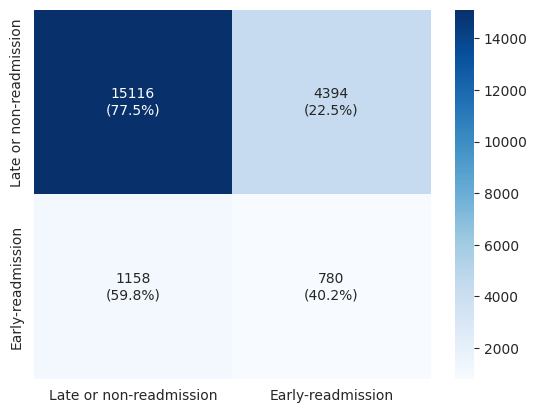

In [123]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [124]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "C": trial.suggest_float("C", 1e-4, 1, log=True),
        "tol": trial.suggest_float("tol", 1e-4, 1e-2, log=True),
        "penalty": "l2",
        "loss": trial.suggest_categorical("loss", ["hinge", "squared_hinge"]),
        "dual": True
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        LinearSVC(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [125]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 17:39:44,712] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [60]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:26:55,105] Trial 1 finished with value: 0.4994723027214434 and parameters: {'C': 0.0005872389221458505, 'tol': 0.00024807029802983554, 'loss': 'squared_hinge'}. Best is trial 1 with value: 0.4994723027214434.


Cross validation scores: [0.50095996 0.4990837  0.50685856 0.49777264 0.49268666]
Average score: 0.4994723027214434


[I 2025-01-12 17:26:57,914] Trial 2 finished with value: 0.5005097356368119 and parameters: {'C': 0.0011321482105039258, 'tol': 0.003191776847485698, 'loss': 'squared_hinge'}. Best is trial 2 with value: 0.5005097356368119.


Cross validation scores: [0.50217171 0.50049413 0.5072222  0.49850133 0.49415931]
Average score: 0.5005097356368119


[I 2025-01-12 17:26:58,253] Trial 8 finished with value: 0.5016264762715906 and parameters: {'C': 0.007433136510281414, 'tol': 0.0005232597095948056, 'loss': 'squared_hinge'}. Best is trial 8 with value: 0.5016264762715906.


Cross validation scores: [0.50388054 0.50232509 0.50721591 0.49964517 0.49506568]
Average score: 0.5016264762715906


[I 2025-01-12 17:26:58,553] Trial 4 finished with value: 0.5127828151034588 and parameters: {'C': 0.000531515271263252, 'tol': 0.0009795139461731422, 'loss': 'hinge'}. Best is trial 4 with value: 0.5127828151034588.
[I 2025-01-12 17:26:58,571] Trial 5 finished with value: 0.49628953212434623 and parameters: {'C': 0.0002584464760395725, 'tol': 0.0008148942438943986, 'loss': 'squared_hinge'}. Best is trial 4 with value: 0.5127828151034588.
[I 2025-01-12 17:26:58,690] Trial 0 finished with value: 0.500111692542783 and parameters: {'C': 0.0007599224786959545, 'tol': 0.002227591220223021, 'loss': 'squared_hinge'}. Best is trial 4 with value: 0.5127828151034588.


Cross validation scores: [0.51313468 0.51327478 0.5182001  0.51214777 0.50715674]
Average score: 0.5127828151034588
Cross validation scores: [0.49799311 0.49467369 0.50506518 0.49470272 0.48901296]
Average score: 0.49628953212434623
Cross validation scores: [0.50211541 0.49998193 0.50687745 0.49849527 0.4930884 ]
Average score: 0.500111692542783


[I 2025-01-12 17:26:59,492] Trial 6 finished with value: 0.46936776180518197 and parameters: {'C': 0.00010160333419899497, 'tol': 0.0002587388191962531, 'loss': 'hinge'}. Best is trial 4 with value: 0.5127828151034588.


Cross validation scores: [0.47420056 0.47007922 0.46940468 0.47035595 0.46279839]
Average score: 0.46936776180518197


[I 2025-01-12 17:27:00,175] Trial 9 finished with value: 0.5250116446704517 and parameters: {'C': 0.006480091128664075, 'tol': 0.00048066580798298544, 'loss': 'hinge'}. Best is trial 9 with value: 0.5250116446704517.


Cross validation scores: [0.52752686 0.53698181 0.52772165 0.51790932 0.51491859]
Average score: 0.5250116446704517


[I 2025-01-12 17:27:00,441] Trial 11 finished with value: 0.5018238003943922 and parameters: {'C': 0.017736851094586586, 'tol': 0.0007994137607155378, 'loss': 'squared_hinge'}. Best is trial 9 with value: 0.5250116446704517.


Cross validation scores: [0.50394496 0.50258266 0.50743566 0.50002693 0.49512879]
Average score: 0.5018238003943922


[I 2025-01-12 17:27:00,871] Trial 10 finished with value: 0.5018031510669058 and parameters: {'C': 0.028268975626355265, 'tol': 0.0008078225771607582, 'loss': 'squared_hinge'}. Best is trial 9 with value: 0.5250116446704517.


Cross validation scores: [0.50371494 0.50258266 0.50743566 0.50009058 0.49519191]
Average score: 0.5018031510669058


[I 2025-01-12 17:27:07,858] Trial 7 finished with value: 0.5316754721211358 and parameters: {'C': 0.1484933732869234, 'tol': 0.0002900698596381859, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.53164042 0.53924286 0.53911736 0.52712676 0.52124995]
Average score: 0.5316754721211358


[I 2025-01-12 17:27:13,624] Trial 3 finished with value: 0.5280012441162205 and parameters: {'C': 0.2818651650140121, 'tol': 0.0010624715410220784, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52510318 0.5397837  0.53544776 0.51958928 0.52008231]
Average score: 0.5280012441162205


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:27:45,402] Trial 15 finished with value: 0.5217528178584472 and parameters: {'C': 0.0057785377943889915, 'tol': 0.00018310546444915782, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.51908293 0.52899885 0.52816152 0.51641115 0.51610963]
Average score: 0.5217528178584472


[I 2025-01-12 17:27:46,538] Trial 13 finished with value: 0.5251428839026724 and parameters: {'C': 0.0014713631542320204, 'tol': 0.0007053163560797295, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52197288 0.53274537 0.52965008 0.52252912 0.51881698]
Average score: 0.5251428839026724


[I 2025-01-12 17:27:48,113] Trial 21 finished with value: 0.5213016656265264 and parameters: {'C': 0.0025978502440901236, 'tol': 0.00010696072071228104, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.51972574 0.52806223 0.52797852 0.51602148 0.51472035]
Average score: 0.5213016656265264


[I 2025-01-12 17:27:48,445] Trial 20 finished with value: 0.526408438976636 and parameters: {'C': 0.004606113311137551, 'tol': 0.00025561644038969586, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.
[I 2025-01-12 17:27:48,592] Trial 16 finished with value: 0.47935166900912246 and parameters: {'C': 0.0001534427785339017, 'tol': 0.0002061958200243344, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.53080687 0.52558373 0.53616653 0.51568203 0.52380302]
Average score: 0.526408438976636
Cross validation scores: [0.48204194 0.48071559 0.48012227 0.48169557 0.47218298]
Average score: 0.47935166900912246


[I 2025-01-12 17:27:48,727] Trial 18 finished with value: 0.5306778700151341 and parameters: {'C': 0.011151015413416053, 'tol': 0.0013398060306262505, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52743232 0.53859437 0.54054022 0.52310344 0.52371901]
Average score: 0.5306778700151341


[I 2025-01-12 17:27:49,218] Trial 17 finished with value: 0.5017905273396776 and parameters: {'C': 0.02013431148702506, 'tol': 0.004947383150585181, 'loss': 'squared_hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.50371494 0.50258266 0.50743566 0.50009058 0.49512879]
Average score: 0.5017905273396776


[I 2025-01-12 17:27:49,888] Trial 19 finished with value: 0.5282799408752308 and parameters: {'C': 0.04062357747660507, 'tol': 0.003997034207853149, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.53270158 0.5310544  0.53404191 0.51968981 0.523912  ]
Average score: 0.5282799408752308


[I 2025-01-12 17:28:00,216] Trial 12 finished with value: 0.5018077046960743 and parameters: {'C': 0.18596445814501109, 'tol': 0.002241248159299099, 'loss': 'squared_hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.50377933 0.50271149 0.50720209 0.50009058 0.49525504]
Average score: 0.5018077046960743


[I 2025-01-12 17:28:00,965] Trial 22 finished with value: 0.5288857065409391 and parameters: {'C': 0.09258992588470953, 'tol': 0.0003570851157545525, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52562635 0.52936323 0.53376176 0.52841653 0.52726067]
Average score: 0.5288857065409391


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:28:17,259] Trial 14 finished with value: 0.5293205555082626 and parameters: {'C': 0.6559860192972234, 'tol': 0.0005331953281436093, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52330817 0.5371627  0.54091983 0.52603904 0.51917303]
Average score: 0.5293205555082626


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:28:38,049] Trial 23 finished with value: 0.5299428430079196 and parameters: {'C': 0.760437293087468, 'tol': 0.006876011078140481, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.
[I 2025-01-12 17:28:38,148] Trial 29 finished with value: 0.5281399941737186 and parameters: {'C': 0.011430832780379438, 'tol': 0.00014133636900981084, 'loss': 'hinge'}. Be

Cross validation scores: [0.53403608 0.5317306  0.53781927 0.52457233 0.52155593]
Average score: 0.5299428430079196
Cross validation scores: [0.53072836 0.53973587 0.53152322 0.52340823 0.51530429]
Average score: 0.5281399941737186


[I 2025-01-12 17:28:39,356] Trial 31 finished with value: 0.5009299327928323 and parameters: {'C': 0.0019517475243583206, 'tol': 0.001766327731307674, 'loss': 'squared_hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.50317235 0.50075104 0.50673702 0.49907298 0.49491627]
Average score: 0.5009299327928323


[I 2025-01-12 17:28:40,890] Trial 25 finished with value: 0.5255244655645923 and parameters: {'C': 0.06866929715565832, 'tol': 0.00010038617913194778, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52883365 0.5352966  0.52597555 0.52303049 0.51448604]
Average score: 0.5255244655645923


[I 2025-01-12 17:28:41,352] Trial 30 finished with value: 0.5255894574417034 and parameters: {'C': 0.056730688795360466, 'tol': 0.002368618931499293, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52236779 0.53646091 0.52600914 0.51576152 0.52734792]
Average score: 0.5255894574417034


[I 2025-01-12 17:28:44,837] Trial 27 finished with value: 0.5280856006342638 and parameters: {'C': 0.10343675021982843, 'tol': 0.009257603411913598, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52694296 0.53247768 0.53586403 0.52620021 0.51894312]
Average score: 0.5280856006342638


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:28:49,512] Trial 24 finished with value: 0.526102041761023 and parameters: {'C': 0.22628530135589697, 'tol': 0.0014338451775015887, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.53156548 0.53179986 0.5287497  0.52007231 0.51832285]
Average score: 0.526102041761023


[I 2025-01-12 17:28:51,644] Trial 32 finished with value: 0.5248596832321037 and parameters: {'C': 0.03969498387387304, 'tol': 0.00396293649108095, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52005955 0.52894852 0.53342157 0.52229823 0.51957055]
Average score: 0.5248596832321037


[I 2025-01-12 17:28:55,816] Trial 26 finished with value: 0.5301447613874751 and parameters: {'C': 0.30519488693740665, 'tol': 0.0012937159858942128, 'loss': 'hinge'}. Best is trial 7 with value: 0.5316754721211358.


Cross validation scores: [0.52195885 0.54364296 0.52997365 0.52842707 0.52672128]
Average score: 0.5301447613874751


[I 2025-01-12 17:28:57,126] Trial 33 finished with value: 0.5324352115930069 and parameters: {'C': 0.08758054167527188, 'tol': 0.0003626676058290791, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.52637644 0.54456253 0.53641116 0.53187707 0.52294885]
Average score: 0.5324352115930069


[I 2025-01-12 17:29:08,772] Trial 28 finished with value: 0.5296263076457992 and parameters: {'C': 0.5825864738860069, 'tol': 0.0003441284436853277, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.52451925 0.54010436 0.53201418 0.52279989 0.52869386]
Average score: 0.5296263076457992


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:29:28,883] Trial 37 finished with value: 0.5229514820014112 and parameters: {'C': 0.0007674251504493951, 'tol': 0.002865115446875347, 'loss': 'hinge'}. Best is tri

Cross validation scores: [0.52045372 0.52606824 0.52863913 0.52195885 0.51763746]
Average score: 0.5229514820014112


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:29:35,443] Trial 34 finished with value: 0.5287691094091779 and parameters: {'C': 0.4879212038407445, 'tol': 0.000588941671069045, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.53394004 0.5288642  0.52915583 0.52354423 0.52834125]
Average score: 0.5287691094091779


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:29:38,437] Trial 35 finished with value: 0.5253459908091914 and parameters: {'C': 0.14083517904414183, 'tol': 0.009379507420269738, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.52319906 0.5312568  0.52942751 0.5233423  0.51950428]
Average score: 0.5253459908091914


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:29:41,448] Trial 41 finished with value: 0.5018109159586026 and parameters: {'C': 0.015420090608170003, 'tol': 0.0029875381507393868, 'loss': 'squared_hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.50388054 0.50258266 0.50743566 0.50002693 0.49512879]
Average score: 0.5018109159586026


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:29:55,094] Trial 39 finished with value: 0.529060131685237 and parameters: {'C': 0.4056086379037459, 'tol': 0.001085657854422455, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.53252288 0.53843498 0.52975476 0.52184025 0.52274779]
Average score: 0.529060131685237


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:29:57,802] Trial 44 finished with value: 0.5234971954660876 and parameters: {'C': 0.13153908298727401, 'tol': 0.0010231260745068665, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.5184214  0.53540905 0.52806774 0.52093311 0.51465468]
Average score: 0.5234971954660876


[I 2025-01-12 17:29:59,360] Trial 43 finished with value: 0.5307341914897554 and parameters: {'C': 0.1979572854253909, 'tol': 0.0012957097482606933, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.52597746 0.53868855 0.53913532 0.52089502 0.5289746 ]
Average score: 0.5307341914897554


[I 2025-01-12 17:30:02,565] Trial 38 finished with value: 0.5018077046960743 and parameters: {'C': 0.3163130967415899, 'tol': 0.006533946059444848, 'loss': 'squared_hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.50377933 0.50271149 0.50720209 0.50009058 0.49525504]
Average score: 0.5018077046960743


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:30:05,716] Trial 36 finished with value: 0.5253640120470487 and parameters: {'C': 0.9577891134451717, 'tol': 0.006711206436921024, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.52287369 0.52748267 0.5287607  0.52805469 0.51964831]
Average score: 0.5253640120470487


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:30:14,004] Trial 40 finished with value: 0.5284296134880383 and parameters: {'C': 0.9766362127878684, 'tol': 0.0016549049853625203, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.5307154  0.52637737 0.52952918 0.53191598 0.52361015]
Average score: 0.5284296134880383


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:30:14,980] Trial 42 finished with value: 0.5321725325272662 and parameters: {'C': 0.6508242669094048, 'tol': 0.0004023606310971098, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.53395422 0.53629665 0.52902403 0.5323001  0.52928766]
Average score: 0.5321725325272662


[I 2025-01-12 17:30:19,395] Trial 45 finished with value: 0.5279176566392187 and parameters: {'C': 0.35055119984429584, 'tol': 0.0006783364234580352, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.52270785 0.53892574 0.54089124 0.51956485 0.5174986 ]
Average score: 0.5279176566392187


[I 2025-01-12 17:30:22,967] Trial 46 finished with value: 0.530296214972471 and parameters: {'C': 0.03426997841936945, 'tol': 0.00030826822485739437, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.53256639 0.53899644 0.53775771 0.51810236 0.52405817]
Average score: 0.530296214972471


[I 2025-01-12 17:30:27,737] Trial 48 finished with value: 0.5017082034419691 and parameters: {'C': 0.009435013830556505, 'tol': 0.0001582838834359343, 'loss': 'squared_hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.50394496 0.50245386 0.5072415  0.49970878 0.49519191]
Average score: 0.5017082034419691


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:30:29,822] Trial 47 finished with value: 0.529174117469419 and parameters: {'C': 0.06521722759552055, 'tol': 0.0004401813684888968, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.53075555 0.5390564  0.53616712 0.52639658 0.51349493]
Average score: 0.529174117469419


[I 2025-01-12 17:30:31,011] Trial 49 finished with value: 0.5039262090088054 and parameters: {'C': 0.00037409211980543746, 'tol': 0.0018030983382920582, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.50861214 0.50133835 0.50767995 0.50326173 0.49873888]
Average score: 0.5039262090088054


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:30:44,015] Trial 50 finished with value: 0.5261149045937591 and parameters: {'C': 0.024286138730357856, 'tol': 0.00022123019328470445, 'loss': 'hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.51686581 0.52855797 0.53186227 0.53198354 0.52130493]
Average score: 0.5261149045937591


[I 2025-01-12 17:30:46,626] Trial 51 finished with value: 0.5012545236392384 and parameters: {'C': 0.003534353678954424, 'tol': 0.0008540453095211012, 'loss': 'squared_hinge'}. Best is trial 33 with value: 0.5324352115930069.


Cross validation scores: [0.50345747 0.50129584 0.50718998 0.49926365 0.49506568]
Average score: 0.5012545236392384


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:31:03,401] Trial 52 finished with value: 0.5330238587778722 and parameters: {'C': 0.18061913718528985, 'tol': 0.0013129334249765967, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53366598 0.53220679 0.54172759 0.52907917 0.52843976]
Average score: 0.5330238587778722


[I 2025-01-12 17:31:07,931] Trial 54 finished with value: 0.5292462142003076 and parameters: {'C': 0.16232087290375058, 'tol': 0.0008873400062447747, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.51973621 0.53794115 0.53953367 0.5242961  0.52472394]
Average score: 0.5292462142003076


[I 2025-01-12 17:31:09,681] Trial 55 finished with value: 0.5297381209660562 and parameters: {'C': 0.10037053512134082, 'tol': 0.0006099782971449123, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53052697 0.54202679 0.53357638 0.52376814 0.51879232]
Average score: 0.5297381209660562


[I 2025-01-12 17:31:10,262] Trial 53 finished with value: 0.5277071735053803 and parameters: {'C': 0.24464197833582366, 'tol': 0.001176242704396626, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52311018 0.53821122 0.53419856 0.52242067 0.52059523]
Average score: 0.5277071735053803


[I 2025-01-12 17:31:13,912] Trial 57 finished with value: 0.5266899368021416 and parameters: {'C': 0.047054060483479127, 'tol': 0.0002888807980807318, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52617754 0.53777556 0.52574643 0.52412553 0.51962463]
Average score: 0.5266899368021416


[I 2025-01-12 17:31:17,296] Trial 58 finished with value: 0.5318298858954197 and parameters: {'C': 0.07570578844231833, 'tol': 0.000378012452989058, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53170388 0.52983903 0.54190467 0.53051765 0.5251842 ]
Average score: 0.5318298858954197


[I 2025-01-12 17:31:28,956] Trial 60 finished with value: 0.5244749531018784 and parameters: {'C': 0.11981946584075046, 'tol': 0.0006820010851602696, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.51731965 0.53699207 0.52916523 0.5190581  0.51983971]
Average score: 0.5244749531018784


[I 2025-01-12 17:31:30,794] Trial 56 finished with value: 0.5257865839816702 and parameters: {'C': 0.47502448438502826, 'tol': 0.00044280015777935076, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52300101 0.53403722 0.5314607  0.52397446 0.51645953]
Average score: 0.5257865839816702


[I 2025-01-12 17:31:32,387] Trial 59 finished with value: 0.5258741298178833 and parameters: {'C': 0.19866228369342098, 'tol': 0.00018244942200427793, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52293502 0.53558475 0.53051175 0.52529207 0.51504706]
Average score: 0.5258741298178833


[I 2025-01-12 17:31:34,915] Trial 62 finished with value: 0.5258165747008446 and parameters: {'C': 0.03374839295232546, 'tol': 0.00012326992264284544, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52566045 0.53350111 0.53561837 0.51647532 0.51782762]
Average score: 0.5258165747008446


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:31:37,365] Trial 63 finished with value: 0.5221460527423102 and parameters: {'C': 0.02638849575137745, 'tol': 0.00030109501283243756, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.51711568 0.52579513 0.52786082 0.51742952 0.52252912]
Average score: 0.5221460527423102


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:31:52,298] Trial 61 finished with value: 0.5260993974238224 and parameters: {'C': 0.6026820854924675, 'tol': 0.00022779351972176937, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.51690072 0.53985667 0.53008325 0.52462628 0.51903007]
Average score: 0.5260993974238224


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:32:06,520] Trial 64 finished with value: 0.5278800084998989 and parameters: {'C': 0.19314780477665197, 'tol': 0.0015007305159754434, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52836747 0.53951389 0.5276219  0.52242067 0.52147611]
Average score: 0.5278800084998989


[I 2025-01-12 17:32:08,437] Trial 68 finished with value: 0.5301221358981081 and parameters: {'C': 0.05307373178647332, 'tol': 0.0025396602059574685, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53044192 0.53403848 0.54041957 0.51679058 0.52892012]
Average score: 0.5301221358981081


[I 2025-01-12 17:32:10,722] Trial 67 finished with value: 0.5316200247445837 and parameters: {'C': 0.16291474668519915, 'tol': 0.00048317821229277154, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53132265 0.529682   0.54019438 0.53057089 0.52633021]
Average score: 0.5316200247445837


[I 2025-01-12 17:32:15,407] Trial 69 finished with value: 0.501854418741885 and parameters: {'C': 0.07386697322211139, 'tol': 0.0003495205931775346, 'loss': 'squared_hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.50377933 0.50271149 0.50743566 0.50009058 0.49525504]
Average score: 0.501854418741885


[I 2025-01-12 17:32:16,037] Trial 65 finished with value: 0.527367008787664 and parameters: {'C': 0.26554182677406374, 'tol': 0.0012612255069505318, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52098194 0.53145963 0.53030769 0.52250432 0.53158147]
Average score: 0.527367008787664


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:32:23,513] Trial 70 finished with value: 0.5306309255163508 and parameters: {'C': 0.07982149185540903, 'tol': 0.00042044576258455727, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52592753 0.5374729  0.5361007  0.52449151 0.52916199]
Average score: 0.5306309255163508


[I 2025-01-12 17:32:27,857] Trial 74 finished with value: 0.5217361525747934 and parameters: {'C': 0.019264027450479042, 'tol': 0.0005444175147695191, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.51650964 0.53349183 0.52620974 0.51600657 0.51646298]
Average score: 0.5217361525747934


[I 2025-01-12 17:32:28,889] Trial 72 finished with value: 0.5277234126114484 and parameters: {'C': 0.09734683431019199, 'tol': 0.0003685759875873265, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.5223462  0.53436098 0.53630947 0.52270154 0.52289887]
Average score: 0.5277234126114484


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:32:33,123] Trial 66 finished with value: 0.5290084249390904 and parameters: {'C': 0.7315424052062585, 'tol': 0.0020875687512460672, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53046971 0.53587114 0.54080415 0.52440219 0.51349493]
Average score: 0.5290084249390904


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:32:42,148] Trial 73 finished with value: 0.5282885194026384 and parameters: {'C': 0.24371142675125904, 'tol': 0.0014206983800492123, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52301378 0.53349897 0.53091956 0.52746233 0.52654795]
Average score: 0.5282885194026384


[I 2025-01-12 17:32:44,550] Trial 71 finished with value: 0.525585529180386 and parameters: {'C': 0.4149496250311923, 'tol': 0.0002519424151568888, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52006173 0.5288534  0.53965497 0.52386022 0.51549733]
Average score: 0.525585529180386


[I 2025-01-12 17:32:52,557] Trial 75 finished with value: 0.5305544841798352 and parameters: {'C': 0.13168089154818716, 'tol': 0.0007579175825702779, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53414305 0.53394684 0.53730245 0.52437861 0.52300147]
Average score: 0.5305544841798352


[I 2025-01-12 17:32:55,931] Trial 76 finished with value: 0.5252770176983519 and parameters: {'C': 0.014195311523750117, 'tol': 0.0009482211779596519, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52144639 0.52562272 0.526076   0.52815089 0.52508908]
Average score: 0.5252770176983519


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:33:10,754] Trial 79 finished with value: 0.5315775493583966 and parameters: {'C': 0.08947319881038068, 'tol': 0.0005022893035198317, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52986372 0.53450585 0.5326665  0.5289746  0.53187707]
Average score: 0.5315775493583966


[I 2025-01-12 17:33:14,286] Trial 78 finished with value: 0.5253056463818707 and parameters: {'C': 0.18402484944125796, 'tol': 0.0003957185789403474, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.524005   0.53166068 0.52909348 0.51718559 0.52458348]
Average score: 0.5253056463818707


[I 2025-01-12 17:33:16,144] Trial 80 finished with value: 0.5268157233724957 and parameters: {'C': 0.15569152671922928, 'tol': 0.0002829036848074538, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52223987 0.53708192 0.52755467 0.52683082 0.52037132]
Average score: 0.5268157233724957


[I 2025-01-12 17:33:17,257] Trial 77 finished with value: 0.5270073716558332 and parameters: {'C': 0.3403357812675787, 'tol': 0.0018971858247847882, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.5223462  0.5265366  0.5389533  0.52237621 0.52482454]
Average score: 0.5270073716558332


[I 2025-01-12 17:33:21,207] Trial 81 finished with value: 0.5018415413724614 and parameters: {'C': 0.06044387107112348, 'tol': 0.000601569172269341, 'loss': 'squared_hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.50371494 0.50271149 0.50743566 0.50009058 0.49525504]
Average score: 0.5018415413724614


[I 2025-01-12 17:33:23,511] Trial 82 finished with value: 0.5295187295084747 and parameters: {'C': 0.10863791795682076, 'tol': 0.0001891244374024503, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53845208 0.53873322 0.53125414 0.52226426 0.51688995]
Average score: 0.5295187295084747


[I 2025-01-12 17:33:31,834] Trial 85 finished with value: 0.5227012276269505 and parameters: {'C': 0.005727427683779736, 'tol': 0.00048376178126900585, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.51836332 0.53083794 0.53349732 0.51595657 0.51485099]
Average score: 0.5227012276269505


[I 2025-01-12 17:33:35,347] Trial 86 finished with value: 0.5283387911130818 and parameters: {'C': 0.046035256942307, 'tol': 0.00040429735743147284, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52742118 0.53319258 0.52714493 0.52618872 0.52774655]
Average score: 0.5283387911130818


[I 2025-01-12 17:33:37,135] Trial 83 finished with value: 0.5267192976121254 and parameters: {'C': 0.2776543761005864, 'tol': 0.0003344141738006101, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52288819 0.52643135 0.54021067 0.52301286 0.52105341]
Average score: 0.5267192976121254


[I 2025-01-12 17:33:42,606] Trial 87 finished with value: 0.5242071117928976 and parameters: {'C': 0.0009243034888059818, 'tol': 0.0009591517117756293, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52164391 0.52926831 0.5306276  0.52139239 0.51810335]
Average score: 0.5242071117928976


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:33:48,990] Trial 84 finished with value: 0.5293109898414039 and parameters: {'C': 0.5220561053675464, 'tol': 0.0011130920117071261, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53332766 0.5349029  0.529602   0.52220762 0.52651476]
Average score: 0.5293109898414039


[I 2025-01-12 17:33:58,825] Trial 88 finished with value: 0.5267548623813176 and parameters: {'C': 0.2126617258250268, 'tol': 0.0015182840370063404, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52550054 0.52665931 0.53713721 0.52981621 0.51466104]
Average score: 0.5267548623813176


[I 2025-01-12 17:34:04,868] Trial 89 finished with value: 0.5266624912825828 and parameters: {'C': 0.08919042409188949, 'tol': 0.0005239615306933641, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53088271 0.52894852 0.5299046  0.52142803 0.52214859]
Average score: 0.5266624912825828


[I 2025-01-12 17:34:08,754] Trial 92 finished with value: 0.5245871179217142 and parameters: {'C': 0.07480901312311838, 'tol': 0.0007623828459928291, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52579459 0.52418343 0.52974174 0.52695081 0.51626501]
Average score: 0.5245871179217142


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-01-12 17:34:11,446] Trial 90 finished with value: 0.5290916756485728 and parameters: {'C': 0.14087223860409823, 'tol': 0.00046782487611114607, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52280308 0.53839732 0.5317126  0.52858204 0.52396334]
Average score: 0.5290916756485728


[I 2025-01-12 17:34:16,805] Trial 93 finished with value: 0.5283938112154551 and parameters: {'C': 0.17388655307959544, 'tol': 0.0002768938297309329, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.
[I 2025-01-12 17:34:16,974] Trial 94 finished with value: 0.5290834192860002 and parameters: {'C': 0.11712198564574287, 'tol': 0.001316101998146465, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52300993 0.53933378 0.53820782 0.52314664 0.51827088]
Average score: 0.5283938112154551
Cross validation scores: [0.52837761 0.5406223  0.53840073 0.51981114 0.51820531]
Average score: 0.5290834192860002


[I 2025-01-12 17:34:18,011] Trial 91 finished with value: 0.5302770447483443 and parameters: {'C': 0.38598343495683746, 'tol': 0.0003212412089186797, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53404572 0.53820439 0.52915583 0.52353682 0.52644247]
Average score: 0.5302770447483443


[I 2025-01-12 17:34:18,454] Trial 95 finished with value: 0.5283106283819073 and parameters: {'C': 0.08652463451014779, 'tol': 0.0006319792813693485, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.
[I 2025-01-12 17:34:18,633] Trial 97 finished with value: 0.501716028613024 and parameters: {'C': 0.00873460241491635, 'tol': 0.0003712247995310203, 'loss': 'squared_hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52537357 0.53731076 0.533771   0.5223198  0.52277801]
Average score: 0.5283106283819073
Cross validation scores: [0.50394496 0.50245386 0.50728063 0.49970878 0.49519191]
Average score: 0.501716028613024


[I 2025-01-12 17:34:18,904] Trial 96 finished with value: 0.5294257331406085 and parameters: {'C': 0.03324123638225463, 'tol': 0.00022132579536310665, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.52689791 0.53402407 0.53204322 0.52457927 0.52958419]
Average score: 0.5294257331406085


[I 2025-01-12 17:34:22,090] Trial 99 finished with value: 0.481271979575806 and parameters: {'C': 0.00016540658649943351, 'tol': 0.0016246923224177503, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.48398195 0.48246591 0.48197589 0.48307582 0.47486033]
Average score: 0.481271979575806


[I 2025-01-12 17:34:25,653] Trial 98 finished with value: 0.5299888265623204 and parameters: {'C': 0.3131848417089068, 'tol': 0.00047159580750809105, 'loss': 'hinge'}. Best is trial 52 with value: 0.5330238587778722.


Cross validation scores: [0.53062077 0.53246614 0.54125768 0.52681791 0.51878162]
Average score: 0.5299888265623204


In [61]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 52
Best Parameters: {'C': 0.18061913718528985, 'tol': 0.0013129334249765967, 'loss': 'hinge'}
Best Value: 0.5330238587778722


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [126]:
optuna.visualization.plot_optimization_history(study)

In [127]:
optuna.visualization.plot_slice(study)

In [128]:
optuna.visualization.plot_param_importances(study)

In [129]:
optuna.visualization.plot_parallel_coordinate(study)

In [130]:
optuna.visualization.plot_contour(study)

In [131]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [132]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"
    
pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    LinearSVC(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('linearsvc',
                 LinearSVC(C=0.18061913718528985, loss='hinge', random_state=38,
                           tol=0.0013129334249765967))])

In [133]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [134]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.7196922769507443
Test accuracy:  0.7183420365535248


In [135]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.75      0.83     19510
      Early-readmission       0.15      0.44      0.22      1938

               accuracy                           0.72     21448
              macro avg       0.54      0.59      0.52     21448
           weighted avg       0.86      0.72      0.77     21448



In [136]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

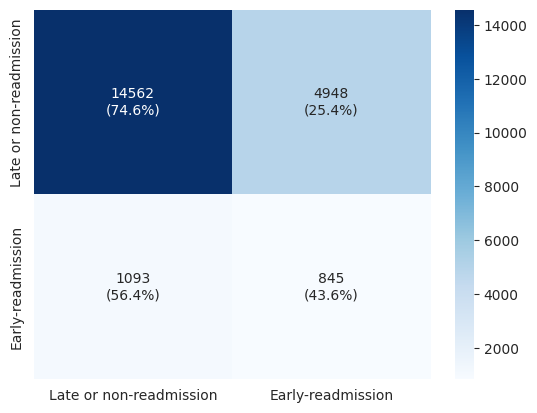

In [137]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

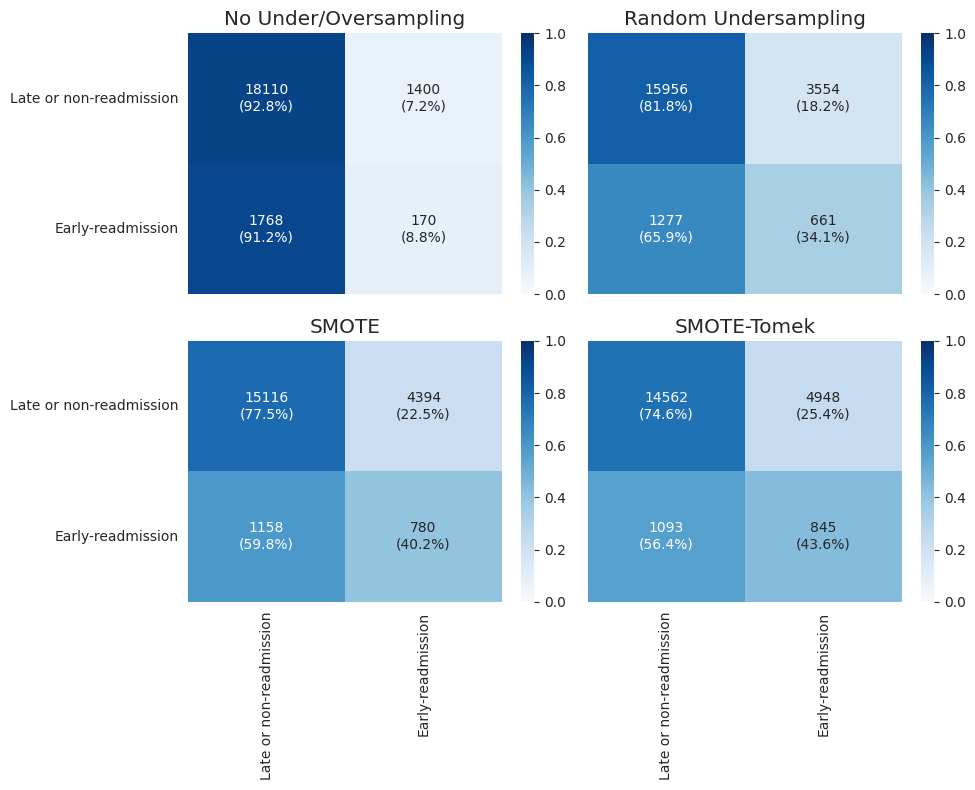

In [138]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [139]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.507981,0.509669,0.508245,0.507981,0.852294
Random Undersampling,0.579455,0.541359,0.541687,0.579455,0.774758
SMOTE,0.588629,0.539799,0.532097,0.588629,0.741141
SMOTE-Tomek,0.591201,0.538024,0.523405,0.591201,0.718342


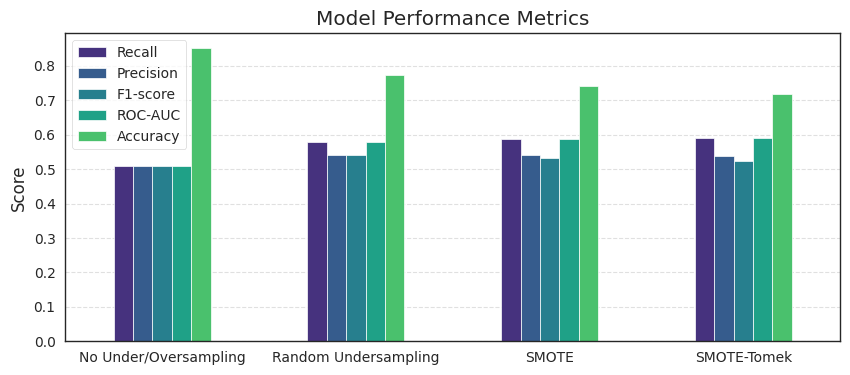

In [140]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()